In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

176


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:48<00:00,  1.81s/it]


In [12]:
Dataset = 'MAP Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 17.58428168296814 [s] ... size 1811.54048 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [14]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [18]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 330911.56it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 66779.42it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:19<00:00,  7.32s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 169924.54it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 18709.95it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252795.82it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [19]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:28<00:00,  2.48s/it]


In [20]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 56368.74it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [21]:

start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:04<00:00,  6.08s/it]


In [22]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 52582.16it/s]


In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [31]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [05:37<00:00,  5.63s/it]


In [32]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 361837.87it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [41]:

print(len(left_files_path))

61


In [42]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [43]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 2000, contrastThreshold=0.02, edgeThreshold=6 )
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:17<00:00,  3.29s/it]


In [44]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252668.92it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [45]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [04:41<00:00,  4.69s/it]


In [46]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 289595.21it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:57<00:00,  2.95s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 48989.34it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [23]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [24]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [25]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [26]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.020707368850708008 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00494694709777832 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [51]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:16,  3.57it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 141
Number of Robust matches 80




  3%|▎         | 2/61 [00:00<00:16,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 183
Number of Robust matches 101




  5%|▍         | 3/61 [00:00<00:16,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 158
Number of Robust matches 57




  7%|▋         | 4/61 [00:01<00:15,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 138
Number of Robust matches 47




  8%|▊         | 5/61 [00:01<00:16,  3.40it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 6
Number of Robust matches 4


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 6




 10%|▉         | 6/61 [00:01<00:15,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 363
Number of Robust matches 195




 11%|█▏        | 7/61 [00:01<00:15,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 166
Number of Robust matches 102




 13%|█▎        | 8/61 [00:02<00:14,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 226
Number of Robust matches 169




 15%|█▍        | 9/61 [00:02<00:14,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 331
Number of Robust matches 256




 16%|█▋        | 10/61 [00:02<00:14,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 348
Number of Robust matches 315




 18%|█▊        | 11/61 [00:03<00:13,  3.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 351
Number of Robust matches 315




 20%|█▉        | 12/61 [00:03<00:13,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 374
Number of Robust matches 348




 21%|██▏       | 13/61 [00:03<00:12,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 318
Number of Robust matches 299




 23%|██▎       | 14/61 [00:03<00:12,  3.76it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 310
Number of Robust matches 301




 25%|██▍       | 15/61 [00:04<00:12,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 301
Number of Robust matches 285




 26%|██▌       | 16/61 [00:04<00:12,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 269
Number of Robust matches 245




 28%|██▊       | 17/61 [00:04<00:11,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 230
Number of Robust matches 210




 30%|██▉       | 18/61 [00:04<00:11,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 312
Number of Robust matches 268




 31%|███       | 19/61 [00:05<00:11,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 365
Number of Robust matches 332




 33%|███▎      | 20/61 [00:05<00:10,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 391
Number of Robust matches 376




 34%|███▍      | 21/61 [00:05<00:10,  3.82it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 393
Number of Robust matches 369




 36%|███▌      | 22/61 [00:05<00:10,  3.75it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 342
Number of Robust matches 300




 38%|███▊      | 23/61 [00:06<00:10,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 312
Number of Robust matches 234




 39%|███▉      | 24/61 [00:06<00:09,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 290
Number of Robust matches 243




 41%|████      | 25/61 [00:06<00:09,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 23
Number of Robust matches 18


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 37




 43%|████▎     | 26/61 [00:07<00:09,  3.73it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 857
Number of Robust matches 852




 44%|████▍     | 27/61 [00:07<00:09,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 427
Number of Robust matches 399




 46%|████▌     | 28/61 [00:07<00:08,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 419
Number of Robust matches 405




 48%|████▊     | 29/61 [00:07<00:08,  3.70it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 427
Number of Robust matches 406




 49%|████▉     | 30/61 [00:08<00:08,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 385
Number of Robust matches 321




 51%|█████     | 31/61 [00:08<00:08,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 346
Number of Robust matches 323




 52%|█████▏    | 32/61 [00:08<00:08,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 273
Number of Robust matches 256




 54%|█████▍    | 33/61 [00:09<00:08,  3.49it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 365
Number of Robust matches 344




 56%|█████▌    | 34/61 [00:09<00:07,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 333
Number of Robust matches 304




 57%|█████▋    | 35/61 [00:09<00:07,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 395
Number of Robust matches 329




 59%|█████▉    | 36/61 [00:09<00:06,  3.70it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 457
Number of Robust matches 439




 61%|██████    | 37/61 [00:10<00:06,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 460
Number of Robust matches 392




 62%|██████▏   | 38/61 [00:10<00:06,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 410
Number of Robust matches 401




 64%|██████▍   | 39/61 [00:10<00:05,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 452
Number of Robust matches 428




 66%|██████▌   | 40/61 [00:10<00:05,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 444
Number of Robust matches 404




 67%|██████▋   | 41/61 [00:11<00:05,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 30
Number of Robust matches 21


Number of matches After Lowe's Ratio New 111
Number of Robust matches New 42




 69%|██████▉   | 42/61 [00:11<00:05,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 777
Number of Robust matches 774




 70%|███████   | 43/61 [00:11<00:04,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 468
Number of Robust matches 445




 72%|███████▏  | 44/61 [00:12<00:04,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 433
Number of Robust matches 391




 74%|███████▍  | 45/61 [00:12<00:04,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 419
Number of Robust matches 404




 75%|███████▌  | 46/61 [00:12<00:04,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 327
Number of Robust matches 283




 77%|███████▋  | 47/61 [00:12<00:03,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 343
Number of Robust matches 327




 79%|███████▊  | 48/61 [00:13<00:03,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 307
Number of Robust matches 305




 80%|████████  | 49/61 [00:13<00:03,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 261
Number of Robust matches 246




 82%|████████▏ | 50/61 [00:13<00:02,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 327
Number of Robust matches 298




 84%|████████▎ | 51/61 [00:13<00:02,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 304
Number of Robust matches 289




 85%|████████▌ | 52/61 [00:14<00:02,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 47
Number of Robust matches 37




 87%|████████▋ | 53/61 [00:14<00:02,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 806
Number of Robust matches 804




 89%|████████▊ | 54/61 [00:14<00:01,  3.72it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 392
Number of Robust matches 364




 90%|█████████ | 55/61 [00:14<00:01,  3.65it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 413
Number of Robust matches 384




 92%|█████████▏| 56/61 [00:15<00:01,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 391
Number of Robust matches 378




 93%|█████████▎| 57/61 [00:15<00:01,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 492
Number of Robust matches 487




 95%|█████████▌| 58/61 [00:15<00:00,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 499
Number of Robust matches 460




 97%|█████████▋| 59/61 [00:16<00:00,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 90
Number of Robust matches 89




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 599
Number of Robust matches 593




  2%|▏         | 1/60 [00:00<00:16,  3.49it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 168
Number of Robust matches 105




  3%|▎         | 2/60 [00:00<00:16,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 172
Number of Robust matches 120




  5%|▌         | 3/60 [00:00<00:16,  3.44it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 178
Number of Robust matches 147




  7%|▋         | 4/60 [00:01<00:15,  3.51it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 253
Number of Robust matches 215




  8%|▊         | 5/60 [00:01<00:15,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 259
Number of Robust matches 223




 10%|█         | 6/60 [00:01<00:15,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 248
Number of Robust matches 217




 12%|█▏        | 7/60 [00:01<00:14,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 285
Number of Robust matches 246




 13%|█▎        | 8/60 [00:02<00:14,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 265
Number of Robust matches 209




 15%|█▌        | 9/60 [00:02<00:14,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 216
Number of Robust matches 185




 17%|█▋        | 10/60 [00:02<00:14,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 210
Number of Robust matches 180




 18%|█▊        | 11/60 [00:03<00:13,  3.53it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 272
Number of Robust matches 233




 20%|██        | 12/60 [00:03<00:13,  3.56it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 412
Number of Robust matches 376




 22%|██▏       | 13/60 [00:03<00:13,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 406
Number of Robust matches 379




 23%|██▎       | 14/60 [00:03<00:12,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 350
Number of Robust matches 338




 25%|██▌       | 15/60 [00:04<00:12,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 370
Number of Robust matches 343




 27%|██▋       | 16/60 [00:04<00:12,  3.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 367
Number of Robust matches 316




 28%|██▊       | 17/60 [00:04<00:11,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 331
Number of Robust matches 273




 30%|███       | 18/60 [00:05<00:11,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 331
Number of Robust matches 287




 32%|███▏      | 19/60 [00:05<00:11,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 410
Number of Robust matches 347




 33%|███▎      | 20/60 [00:05<00:11,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 762
Number of Robust matches 754




 35%|███▌      | 21/60 [00:05<00:10,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 63
Number of Robust matches 56




 37%|███▋      | 22/60 [00:06<00:10,  3.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 550
Number of Robust matches 541




 38%|███▊      | 23/60 [00:06<00:09,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 536
Number of Robust matches 522




 40%|████      | 24/60 [00:06<00:09,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 447
Number of Robust matches 434




 42%|████▏     | 25/60 [00:06<00:09,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 371
Number of Robust matches 330




 43%|████▎     | 26/60 [00:07<00:09,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 372
Number of Robust matches 330




 45%|████▌     | 27/60 [00:07<00:09,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 316
Number of Robust matches 272




 47%|████▋     | 28/60 [00:07<00:08,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 325
Number of Robust matches 259




 48%|████▊     | 29/60 [00:08<00:08,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 381
Number of Robust matches 359




 50%|█████     | 30/60 [00:08<00:08,  3.55it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 360
Number of Robust matches 334




 52%|█████▏    | 31/60 [00:08<00:08,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 264
Number of Robust matches 207




 53%|█████▎    | 32/60 [00:08<00:07,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 309
Number of Robust matches 230




 55%|█████▌    | 33/60 [00:09<00:07,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 254
Number of Robust matches 203




 57%|█████▋    | 34/60 [00:09<00:07,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 277
Number of Robust matches 227




 58%|█████▊    | 35/60 [00:09<00:06,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 258
Number of Robust matches 212




 60%|██████    | 36/60 [00:09<00:06,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 272
Number of Robust matches 233




 62%|██████▏   | 37/60 [00:10<00:06,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 223
Number of Robust matches 178




 63%|██████▎   | 38/60 [00:10<00:06,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 257
Number of Robust matches 186




 65%|██████▌   | 39/60 [00:10<00:05,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 193
Number of Robust matches 113




 67%|██████▋   | 40/60 [00:11<00:05,  3.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 118
Number of Robust matches 65




 68%|██████▊   | 41/60 [00:11<00:05,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 95
Number of Robust matches 57




 70%|███████   | 42/60 [00:11<00:05,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 162
Number of Robust matches 64




 72%|███████▏  | 43/60 [00:11<00:04,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 137
Number of Robust matches 59




 73%|███████▎  | 44/60 [00:12<00:04,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 184
Number of Robust matches 74




 75%|███████▌  | 45/60 [00:12<00:04,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 191
Number of Robust matches 72




 77%|███████▋  | 46/60 [00:12<00:03,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 168
Number of Robust matches 53




 78%|███████▊  | 47/60 [00:13<00:03,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 185
Number of Robust matches 68




 80%|████████  | 48/60 [00:13<00:03,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 185
Number of Robust matches 66




 82%|████████▏ | 49/60 [00:13<00:03,  3.56it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 370
Number of Robust matches 168




 83%|████████▎ | 50/60 [00:13<00:03,  3.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 9
Number of Robust matches 5


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 9




 85%|████████▌ | 51/60 [00:14<00:02,  3.38it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 100
Number of Robust matches 67




 87%|████████▋ | 52/60 [00:14<00:02,  3.39it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 187
Number of Robust matches 70




 88%|████████▊ | 53/60 [00:14<00:02,  3.49it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 164
Number of Robust matches 64




 90%|█████████ | 54/60 [00:15<00:01,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 234
Number of Robust matches 97




 92%|█████████▏| 55/60 [00:15<00:01,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 207
Number of Robust matches 81




 93%|█████████▎| 56/60 [00:15<00:01,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 223
Number of Robust matches 94




 95%|█████████▌| 57/60 [00:15<00:00,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 190
Number of Robust matches 78




 97%|█████████▋| 58/60 [00:16<00:00,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 183
Number of Robust matches 77




 98%|█████████▊| 59/60 [00:16<00:00,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 182
Number of Robust matches 77




In [52]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0030765533447265625 [s] ... size 0.006368 MB


In [53]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006323099136352539 [s] ... size 0.006296 MB


In [54]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [33]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 87942
Number of matches After Lowe's Ratio 43535


  2%|▏         | 1/61 [00:22<22:07, 22.12s/it]

Number of Robust matches 32066



Number of matches 88142
Number of matches After Lowe's Ratio 42112


  3%|▎         | 2/61 [00:44<21:45, 22.13s/it]

Number of Robust matches 31014



Number of matches 91103
Number of matches After Lowe's Ratio 41016


  5%|▍         | 3/61 [01:06<21:33, 22.29s/it]

Number of Robust matches 22077




  7%|▋         | 4/61 [01:32<21:59, 23.15s/it]


Number of matches 92490
Number of matches After Lowe's Ratio 22655
Number of Robust matches 13979



Number of matches 100977
Number of matches After Lowe's Ratio 1916
Number of Robust matches 8


Number of matches After Lowe's Ratio New 193


  8%|▊         | 5/61 [01:58<22:32, 24.16s/it]

Number of Robust matches New 6



Number of matches 84962
Number of matches After Lowe's Ratio 59480


 10%|▉         | 6/61 [02:22<22:00, 24.01s/it]

Number of Robust matches 50043



Number of matches 84642
Number of matches After Lowe's Ratio 44666


 11%|█▏        | 7/61 [02:44<21:02, 23.38s/it]

Number of Robust matches 38845



Number of matches 76462
Number of matches After Lowe's Ratio 43441


 13%|█▎        | 8/61 [03:04<19:54, 22.53s/it]

Number of Robust matches 33992



Number of matches 71105
Number of matches After Lowe's Ratio 41934


 15%|█▍        | 9/61 [03:24<18:46, 21.67s/it]

Number of Robust matches 37225



Number of matches 71259
Number of matches After Lowe's Ratio 41031


 16%|█▋        | 10/61 [03:43<17:41, 20.82s/it]

Number of Robust matches 31305



Number of matches 65599
Number of matches After Lowe's Ratio 38030


 18%|█▊        | 11/61 [04:01<16:43, 20.07s/it]

Number of Robust matches 29157



Number of matches 67356
Number of matches After Lowe's Ratio 38703


 20%|█▉        | 12/61 [04:18<15:41, 19.22s/it]

Number of Robust matches 34355



Number of matches 62317
Number of matches After Lowe's Ratio 35495


 21%|██▏       | 13/61 [04:35<14:51, 18.58s/it]

Number of Robust matches 29707



Number of matches 59892
Number of matches After Lowe's Ratio 35037


 23%|██▎       | 14/61 [04:51<13:47, 17.60s/it]

Number of Robust matches 30755



Number of matches 57463
Number of matches After Lowe's Ratio 34062


 25%|██▍       | 15/61 [05:06<12:59, 16.94s/it]

Number of Robust matches 27783




 26%|██▌       | 16/61 [05:21<12:08, 16.19s/it]


Number of matches 53902
Number of matches After Lowe's Ratio 31710
Number of Robust matches 25719




 28%|██▊       | 17/61 [05:34<11:20, 15.46s/it]


Number of matches 48456
Number of matches After Lowe's Ratio 27723
Number of Robust matches 22254




 30%|██▉       | 18/61 [05:47<10:31, 14.69s/it]


Number of matches 48891
Number of matches After Lowe's Ratio 27992
Number of Robust matches 22726




 31%|███       | 19/61 [06:00<09:51, 14.07s/it]


Number of matches 44850
Number of matches After Lowe's Ratio 25375
Number of Robust matches 18804



Number of matches 46034
Number of matches After Lowe's Ratio 25316


 33%|███▎      | 20/61 [06:12<09:07, 13.36s/it]

Number of Robust matches 16775




 34%|███▍      | 21/61 [06:23<08:34, 12.86s/it]


Number of matches 46214
Number of matches After Lowe's Ratio 25590
Number of Robust matches 18109




 36%|███▌      | 22/61 [06:35<08:14, 12.67s/it]


Number of matches 47713
Number of matches After Lowe's Ratio 25710
Number of Robust matches 22223




 38%|███▊      | 23/61 [06:48<07:57, 12.55s/it]


Number of matches 43970
Number of matches After Lowe's Ratio 24321
Number of Robust matches 20566




 39%|███▉      | 24/61 [07:00<07:40, 12.43s/it]


Number of matches 50762
Number of matches After Lowe's Ratio 18518
Number of Robust matches 15089




 41%|████      | 25/61 [07:14<07:42, 12.84s/it]


Number of matches 53639
Number of matches After Lowe's Ratio 1395
Number of Robust matches 9


Number of matches After Lowe's Ratio New 161
Number of Robust matches New 6



Number of matches 53773
Number of matches After Lowe's Ratio 42567


 43%|████▎     | 26/61 [07:28<07:46, 13.32s/it]

Number of Robust matches 38428




 44%|████▍     | 27/61 [07:41<07:30, 13.25s/it]


Number of matches 44824
Number of matches After Lowe's Ratio 27433
Number of Robust matches 24816




 46%|████▌     | 28/61 [07:53<07:02, 12.79s/it]


Number of matches 44896
Number of matches After Lowe's Ratio 24196
Number of Robust matches 21474




 48%|████▊     | 29/61 [08:05<06:42, 12.57s/it]


Number of matches 49029
Number of matches After Lowe's Ratio 26615
Number of Robust matches 23515




 49%|████▉     | 30/61 [08:17<06:28, 12.55s/it]


Number of matches 45188
Number of matches After Lowe's Ratio 25971
Number of Robust matches 21489




 51%|█████     | 31/61 [08:29<06:08, 12.27s/it]


Number of matches 45425
Number of matches After Lowe's Ratio 25176
Number of Robust matches 20457




 52%|█████▏    | 32/61 [08:42<05:57, 12.34s/it]


Number of matches 51760
Number of matches After Lowe's Ratio 27184
Number of Robust matches 22383




 54%|█████▍    | 33/61 [08:56<05:59, 12.84s/it]


Number of matches 52575
Number of matches After Lowe's Ratio 29824
Number of Robust matches 22240



Number of matches 56977
Number of matches After Lowe's Ratio 32159
Number of Robust matches 27462




 56%|█████▌    | 34/61 [09:10<06:02, 13.43s/it]


Number of matches 62432
Number of matches After Lowe's Ratio 36371


 57%|█████▋    | 35/61 [09:27<06:12, 14.33s/it]

Number of Robust matches 28370



Number of matches 63614
Number of matches After Lowe's Ratio 37276


 59%|█████▉    | 36/61 [09:44<06:18, 15.16s/it]

Number of Robust matches 28289



Number of matches 65844
Number of matches After Lowe's Ratio 38726


 61%|██████    | 37/61 [10:01<06:15, 15.66s/it]

Number of Robust matches 32570



Number of matches 72213
Number of matches After Lowe's Ratio 41416


 62%|██████▏   | 38/61 [10:19<06:14, 16.30s/it]

Number of Robust matches 32442



Number of matches 67930
Number of matches After Lowe's Ratio 40254


 64%|██████▍   | 39/61 [10:37<06:14, 17.02s/it]

Number of Robust matches 32479



Number of matches 85018
Number of matches After Lowe's Ratio 31940


 66%|██████▌   | 40/61 [10:57<06:13, 17.79s/it]

Number of Robust matches 28528



Number of matches 84024
Number of matches After Lowe's Ratio 1672
Number of Robust matches 9


Number of matches After Lowe's Ratio New 149


 67%|██████▋   | 41/61 [11:18<06:16, 18.84s/it]

Number of Robust matches New 6



Number of matches 74793
Number of matches After Lowe's Ratio 58154


 69%|██████▉   | 42/61 [11:39<06:07, 19.34s/it]

Number of Robust matches 55436



Number of matches 70872
Number of matches After Lowe's Ratio 44823


 70%|███████   | 43/61 [11:58<05:49, 19.43s/it]

Number of Robust matches 42032



Number of matches 66931
Number of matches After Lowe's Ratio 41867


 72%|███████▏  | 44/61 [12:17<05:26, 19.19s/it]

Number of Robust matches 39052



Number of matches 62477
Number of matches After Lowe's Ratio 39063


 74%|███████▍  | 45/61 [12:35<05:03, 19.00s/it]

Number of Robust matches 36782



Number of matches 61689
Number of matches After Lowe's Ratio 37732


 75%|███████▌  | 46/61 [12:53<04:37, 18.52s/it]

Number of Robust matches 31363



Number of matches 61604
Number of matches After Lowe's Ratio 37654


 77%|███████▋  | 47/61 [13:10<04:11, 17.99s/it]

Number of Robust matches 35677



Number of matches 63790
Number of matches After Lowe's Ratio 38500


 79%|███████▊  | 48/61 [13:27<03:52, 17.91s/it]

Number of Robust matches 35371



Number of matches 60684
Number of matches After Lowe's Ratio 34713


 80%|████████  | 49/61 [13:44<03:29, 17.49s/it]

Number of Robust matches 32283




 82%|████████▏ | 50/61 [14:00<03:07, 17.00s/it]


Number of matches 59529
Number of matches After Lowe's Ratio 32867
Number of Robust matches 30174



Number of matches 71125
Number of matches After Lowe's Ratio 23682


 84%|████████▎ | 51/61 [14:17<02:51, 17.16s/it]

Number of Robust matches 16137




 85%|████████▌ | 52/61 [14:35<02:36, 17.37s/it]


Number of matches 65126
Number of matches After Lowe's Ratio 1403
Number of Robust matches 8


Number of matches After Lowe's Ratio New 136
Number of Robust matches New 7



Number of matches 65063
Number of matches After Lowe's Ratio 51749


 87%|████████▋ | 53/61 [14:53<02:20, 17.54s/it]

Number of Robust matches 48095




 89%|████████▊ | 54/61 [15:09<01:58, 16.97s/it]


Number of matches 50603
Number of matches After Lowe's Ratio 32641
Number of Robust matches 30820




 90%|█████████ | 55/61 [15:22<01:35, 15.95s/it]


Number of matches 56165
Number of matches After Lowe's Ratio 32791
Number of Robust matches 24700



Number of matches 56355
Number of matches After Lowe's Ratio 33872


 92%|█████████▏| 56/61 [15:37<01:18, 15.64s/it]

Number of Robust matches 29058




 93%|█████████▎| 57/61 [15:53<01:02, 15.57s/it]


Number of matches 60133
Number of matches After Lowe's Ratio 34756
Number of Robust matches 28794



Number of matches 70983
Number of matches After Lowe's Ratio 27754


 95%|█████████▌| 58/61 [16:11<00:49, 16.49s/it]

Number of Robust matches 21052



Number of matches 64035
Number of matches After Lowe's Ratio 1583
Number of Robust matches 7


Number of matches After Lowe's Ratio New 161


 97%|█████████▋| 59/61 [16:30<00:34, 17.13s/it]

Number of Robust matches New 8



Number of matches 61096
Number of matches After Lowe's Ratio 43081


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 37309



Number of matches 88493
Number of matches After Lowe's Ratio 45714


  2%|▏         | 1/60 [00:23<22:52, 23.26s/it]

Number of Robust matches 38081



Number of matches 80756
Number of matches After Lowe's Ratio 42182


  3%|▎         | 2/60 [00:45<22:18, 23.07s/it]

Number of Robust matches 32326



Number of matches 79185
Number of matches After Lowe's Ratio 40700


  5%|▌         | 3/60 [01:06<21:20, 22.46s/it]

Number of Robust matches 37002



Number of matches 67578
Number of matches After Lowe's Ratio 36591


  7%|▋         | 4/60 [01:26<20:15, 21.71s/it]

Number of Robust matches 32165



Number of matches 75349
Number of matches After Lowe's Ratio 39188


  8%|▊         | 5/60 [01:45<19:06, 20.85s/it]

Number of Robust matches 34634



Number of matches 69191
Number of matches After Lowe's Ratio 36891


 10%|█         | 6/60 [02:05<18:22, 20.42s/it]

Number of Robust matches 34300



Number of matches 64234
Number of matches After Lowe's Ratio 34366
Number of Robust matches 28987




 12%|█▏        | 7/60 [02:23<17:33, 19.88s/it]


Number of matches 60665
Number of matches After Lowe's Ratio 32699
Number of Robust matches

 13%|█▎        | 8/60 [02:40<16:31, 19.07s/it]

 29162




 15%|█▌        | 9/60 [02:57<15:30, 18.24s/it]


Number of matches 56897
Number of matches After Lowe's Ratio 31715
Number of Robust matches 26807




 17%|█▋        | 10/60 [03:12<14:23, 17.28s/it]


Number of matches 56665
Number of matches After Lowe's Ratio 31417
Number of Robust matches 28042




 18%|█▊        | 11/60 [03:26<13:15, 16.23s/it]


Number of matches 49271
Number of matches After Lowe's Ratio 28183
Number of Robust matches 25749




 20%|██        | 12/60 [03:38<12:09, 15.20s/it]


Number of matches 46697
Number of matches After Lowe's Ratio 26331
Number of Robust matches 19389




 22%|██▏       | 13/60 [03:50<11:06, 14.17s/it]


Number of matches 43461
Number of matches After Lowe's Ratio 23651
Number of Robust matches 19880



Number of matches 42513
Number of matches After Lowe's Ratio 22756


 23%|██▎       | 14/60 [04:01<10:07, 13.20s/it]

Number of Robust matches 20876




 25%|██▌       | 15/60 [04:11<09:13, 12.31s/it]


Number of matches 40568
Number of matches After Lowe's Ratio 21667
Number of Robust matches 17756




 27%|██▋       | 16/60 [04:21<08:31, 11.63s/it]


Number of matches 40951
Number of matches After Lowe's Ratio 21277
Number of Robust matches 18593



Number of matches 42481
Number of matches After Lowe's Ratio 22408


 28%|██▊       | 17/60 [04:32<08:02, 11.23s/it]

Number of Robust matches 16154




 30%|███       | 18/60 [04:41<07:33, 10.81s/it]


Number of matches 36782
Number of matches After Lowe's Ratio 20138
Number of Robust matches 17067




 32%|███▏      | 19/60 [04:51<07:07, 10.43s/it]


Number of matches 39419
Number of matches After Lowe's Ratio 21826
Number of Robust matches 18919



Number of matches 41500
Number of matches After Lowe's Ratio 30257


 33%|███▎      | 20/60 [05:01<06:55, 10.38s/it]

Number of Robust matches 25917




 35%|███▌      | 21/60 [05:12<06:48, 10.46s/it]


Number of matches 45278
Number of matches After Lowe's Ratio 1332
Number of Robust matches 9


Number of matches After Lowe's Ratio New 164
Number of Robust matches New 7




 37%|███▋      | 22/60 [05:23<06:40, 10.54s/it]


Number of matches 38370
Number of matches After Lowe's Ratio 16365
Number of Robust matches 15234



Number of matches 37503
Number of matches After Lowe's Ratio 20621


 38%|███▊      | 23/60 [05:32<06:18, 10.23s/it]

Number of Robust matches 15743




 40%|████      | 24/60 [05:41<05:56,  9.90s/it]


Number of matches 38399
Number of matches After Lowe's Ratio 20946
Number of Robust matches 19317




 42%|████▏     | 25/60 [05:51<05:45,  9.87s/it]


Number of matches 38819
Number of matches After Lowe's Ratio 20271
Number of Robust matches 17867




 43%|████▎     | 26/60 [06:01<05:37,  9.92s/it]


Number of matches 40442
Number of matches After Lowe's Ratio 21334
Number of Robust matches 16551




 45%|████▌     | 27/60 [06:11<05:29,  9.99s/it]


Number of matches 41950
Number of matches After Lowe's Ratio 21317
Number of Robust matches 17238




 47%|████▋     | 28/60 [06:23<05:32, 10.38s/it]


Number of matches 46536
Number of matches After Lowe's Ratio 23340
Number of Robust matches 18439




 48%|████▊     | 29/60 [06:36<05:46, 11.17s/it]


Number of matches 52007
Number of matches After Lowe's Ratio 27944
Number of Robust matches 25387




 50%|█████     | 30/60 [06:50<06:02, 12.08s/it]


Number of matches 55008
Number of matches After Lowe's Ratio 30454
Number of Robust matches 27411



Number of matches 59736
Number of matches After Lowe's Ratio 31138
Number of Robust matches 28963




 52%|█████▏    | 31/60 [07:05<06:19, 13.09s/it]


Number of matches 61840
Number of matches After Lowe's Ratio 36018


 53%|█████▎    | 32/60 [07:22<06:40, 14.30s/it]

Number of Robust matches 33008




 55%|█████▌    | 33/60 [07:39<06:44, 14.99s/it]


Number of matches 59907
Number of matches After Lowe's Ratio 32162
Number of Robust matches 25836



Number of matches 66001
Number of matches After Lowe's Ratio 33815


 57%|█████▋    | 34/60 [07:57<06:51, 15.81s/it]

Number of Robust matches 28684



Number of matches 69471
Number of matches After Lowe's Ratio 35799


 58%|█████▊    | 35/60 [08:17<07:08, 17.13s/it]

Number of Robust matches 30439



Number of matches 76346
Number of matches After Lowe's Ratio 39226


 60%|██████    | 36/60 [08:37<07:11, 17.98s/it]

Number of Robust matches 34562



Number of matches 82951
Number of matches After Lowe's Ratio 42712


 62%|██████▏   | 37/60 [08:58<07:17, 19.03s/it]

Number of Robust matches 32589



Number of matches 84949
Number of matches After Lowe's Ratio 45793


 63%|██████▎   | 38/60 [09:21<07:19, 20.00s/it]

Number of Robust matches 39995



Number of matches 100364
Number of matches After Lowe's Ratio 50850


 65%|██████▌   | 39/60 [09:45<07:26, 21.24s/it]

Number of Robust matches 41996



Number of matches 102712
Number of matches After Lowe's Ratio 50970


 67%|██████▋   | 40/60 [10:14<07:51, 23.60s/it]

Number of Robust matches 38414



Number of matches 98458
Number of matches After Lowe's Ratio 48822


 68%|██████▊   | 41/60 [10:43<07:59, 25.24s/it]

Number of Robust matches 40821



Number of matches 96036
Number of matches After Lowe's Ratio 47708


 70%|███████   | 42/60 [11:11<07:50, 26.15s/it]

Number of Robust matches 39083



Number of matches 90496
Number of matches After Lowe's Ratio 42936


 72%|███████▏  | 43/60 [11:38<07:29, 26.43s/it]

Number of Robust matches 33144



Number of matches 93722
Number of matches After Lowe's Ratio 40513


 73%|███████▎  | 44/60 [12:05<07:02, 26.41s/it]

Number of Robust matches 21777



Number of matches 89071
Number of matches After Lowe's Ratio 38964


 75%|███████▌  | 45/60 [12:32<06:38, 26.56s/it]

Number of Robust matches 25745



Number of matches 87790
Number of matches After Lowe's Ratio 35313


 77%|███████▋  | 46/60 [12:55<05:58, 25.63s/it]

Number of Robust matches 17981



Number of matches 86303
Number of matches After Lowe's Ratio 33279


 78%|███████▊  | 47/60 [13:18<05:22, 24.80s/it]

Number of Robust matches 15538



Number of matches 79981
Number of matches After Lowe's Ratio 31540
Number of Robust matches 15646




 80%|████████  | 48/60 [13:40<04:49, 24.12s/it]


Number of matches 79243
Number of matches After Lowe's Ratio 42374


 82%|████████▏ | 49/60 [14:02<04:16, 23.33s/it]

Number of Robust matches 18390




 83%|████████▎ | 50/60 [14:20<03:37, 21.70s/it]


Number of matches 52793
Number of matches After Lowe's Ratio 1181
Number of Robust matches 13


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 14




 85%|████████▌ | 51/60 [14:33<02:51, 19.02s/it]


Number of matches 50136
Number of matches After Lowe's Ratio 11310
Number of Robust matches 7857




 87%|████████▋ | 52/60 [14:46<02:19, 17.43s/it]


Number of matches 65140
Number of matches After Lowe's Ratio 22698
Number of Robust matches 15587




 88%|████████▊ | 53/60 [15:06<02:06, 18.02s/it]


Number of matches 78747
Number of matches After Lowe's Ratio 28352
Number of Robust matches 18291




 90%|█████████ | 54/60 [15:25<01:51, 18.51s/it]


Number of matches 67992
Number of matches After Lowe's Ratio 27681
Number of Robust matches 17099




 92%|█████████▏| 55/60 [15:43<01:31, 18.22s/it]


Number of matches 70007
Number of matches After Lowe's Ratio 25633
Number of Robust matches 11354




 93%|█████████▎| 56/60 [16:02<01:14, 18.56s/it]


Number of matches 71962
Number of matches After Lowe's Ratio 27835
Number of Robust matches 14133



Number of matches 81161
Number of matches After Lowe's Ratio 32119


 95%|█████████▌| 57/60 [16:22<00:57, 19.01s/it]

Number of Robust matches 14417



Number of matches 79712
Number of matches After Lowe's Ratio 33559
Number of Robust matches 21157




 97%|█████████▋| 58/60 [16:43<00:39, 19.59s/it]


Number of matches 85824
Number of matches After Lowe's Ratio 38517


 98%|█████████▊| 59/60 [17:05<00:20, 20.26s/it]

Number of Robust matches 25506




In [34]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03728485107421875 [s] ... size 0.006368 MB


In [35]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006269931793212891 [s] ... size 0.006296 MB


In [36]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007542133331298828 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011137247085571289 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0066378116607666016 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.0036492347717285156 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008526325225830078 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008221626281738281 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007969856262207031 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006999015808105469 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [27]:

H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 95764
Number of matches After Lowe's Ratio 39655


  2%|▏         | 1/61 [00:30<30:19, 30.33s/it]

Number of Robust matches 33730



Number of matches 96037
Number of matches After Lowe's Ratio 37382


  3%|▎         | 2/61 [00:55<28:15, 28.73s/it]

Number of Robust matches 28382



Number of matches 99416
Number of matches After Lowe's Ratio 35625


  5%|▍         | 3/61 [01:19<26:34, 27.49s/it]

Number of Robust matches 27509



Number of matches 101347
Number of matches After Lowe's Ratio 15165


  7%|▋         | 4/61 [01:45<25:33, 26.89s/it]

Number of Robust matches 10073



Number of matches 110221
Number of matches After Lowe's Ratio 177
Number of Robust matches 10


Number of matches After Lowe's Ratio New 177
Number of Robust matches New 10




  8%|▊         | 5/61 [02:11<24:51, 26.63s/it]


Number of matches 91850
Number of matches After Lowe's Ratio 57720


 10%|▉         | 6/61 [02:37<24:13, 26.42s/it]

Number of Robust matches 46771



Number of matches 91591
Number of matches After Lowe's Ratio 41715


 11%|█▏        | 7/61 [03:00<22:59, 25.54s/it]

Number of Robust matches 35759



Number of matches 82226
Number of matches After Lowe's Ratio 40834


 13%|█▎        | 8/61 [03:23<21:42, 24.57s/it]

Number of Robust matches 32805



Number of matches 76716
Number of matches After Lowe's Ratio 39726


 15%|█▍        | 9/61 [03:43<20:14, 23.35s/it]

Number of Robust matches 34775



Number of matches 76706
Number of matches After Lowe's Ratio 39387


 16%|█▋        | 10/61 [04:03<18:54, 22.25s/it]

Number of Robust matches 36548



Number of matches 70331
Number of matches After Lowe's Ratio 36605


 18%|█▊        | 11/61 [04:22<17:40, 21.21s/it]

Number of Robust matches 35392



Number of matches 72534
Number of matches After Lowe's Ratio 37695


 20%|█▉        | 12/61 [04:40<16:38, 20.39s/it]

Number of Robust matches 35133



Number of matches 66877
Number of matches After Lowe's Ratio 33776


 21%|██▏       | 13/61 [04:58<15:47, 19.73s/it]

Number of Robust matches 25145



Number of matches 64312
Number of matches After Lowe's Ratio 33414


 23%|██▎       | 14/61 [05:16<14:53, 19.00s/it]

Number of Robust matches 27477




 25%|██▍       | 15/61 [05:32<14:00, 18.28s/it]


Number of matches 61703
Number of matches After Lowe's Ratio 32265
Number of Robust matches 30114




 26%|██▌       | 16/61 [05:49<13:15, 17.69s/it]


Number of matches 57956
Number of matches After Lowe's Ratio 29851
Number of Robust matches 27850




 28%|██▊       | 17/61 [06:03<12:21, 16.84s/it]


Number of matches 52011
Number of matches After Lowe's Ratio 25665
Number of Robust matches 23887




 30%|██▉       | 18/61 [06:17<11:24, 15.92s/it]


Number of matches 52491
Number of matches After Lowe's Ratio 26012
Number of Robust matches 20514




 31%|███       | 19/61 [06:30<10:34, 15.11s/it]


Number of matches 48117
Number of matches After Lowe's Ratio 23619
Number of Robust matches 19941




 33%|███▎      | 20/61 [06:43<09:44, 14.25s/it]


Number of matches 49305
Number of matches After Lowe's Ratio 23372
Number of Robust matches 17672




 34%|███▍      | 21/61 [06:55<09:13, 13.83s/it]


Number of matches 49519
Number of matches After Lowe's Ratio 24092
Number of Robust matches 20053




 36%|███▌      | 22/61 [07:09<08:53, 13.68s/it]


Number of matches 51238
Number of matches After Lowe's Ratio 24368
Number of Robust matches 20219




 38%|███▊      | 23/61 [07:22<08:31, 13.47s/it]


Number of matches 47205
Number of matches After Lowe's Ratio 22447
Number of Robust matches 20042




 39%|███▉      | 24/61 [07:35<08:15, 13.39s/it]


Number of matches 54791
Number of matches After Lowe's Ratio 14153
Number of Robust matches 10639




 41%|████      | 25/61 [07:50<08:18, 13.84s/it]


Number of matches 57589
Number of matches After Lowe's Ratio 139
Number of Robust matches 6


Number of matches After Lowe's Ratio New 139
Number of Robust matches New 6



Number of matches 57862
Number of matches After Lowe's Ratio 43168


 43%|████▎     | 26/61 [08:05<08:19, 14.27s/it]

Number of Robust matches 38981




 44%|████▍     | 27/61 [08:19<08:00, 14.12s/it]


Number of matches 47783
Number of matches After Lowe's Ratio 25536
Number of Robust matches 23155




 46%|████▌     | 28/61 [08:31<07:29, 13.61s/it]


Number of matches 48047
Number of matches After Lowe's Ratio 22533
Number of Robust matches 20532




 48%|████▊     | 29/61 [08:44<07:08, 13.38s/it]


Number of matches 52440
Number of matches After Lowe's Ratio 24805
Number of Robust matches 21662




 49%|████▉     | 30/61 [08:58<06:56, 13.45s/it]


Number of matches 48145
Number of matches After Lowe's Ratio 24123
Number of Robust matches 20441




 51%|█████     | 31/61 [09:10<06:30, 13.02s/it]


Number of matches 48440
Number of matches After Lowe's Ratio 23253
Number of Robust matches 18526




 52%|█████▏    | 32/61 [09:24<06:24, 13.25s/it]


Number of matches 55468
Number of matches After Lowe's Ratio 25452
Number of Robust matches 23813



Number of matches 56355
Number of matches After Lowe's Ratio 28104


 54%|█████▍    | 33/61 [09:39<06:28, 13.86s/it]

Number of Robust matches 26246




 56%|█████▌    | 34/61 [09:54<06:24, 14.25s/it]


Number of matches 61016
Number of matches After Lowe's Ratio 30780
Number of Robust matches 29585



Number of matches 66996
Number of matches After Lowe's Ratio 34651


 57%|█████▋    | 35/61 [10:13<06:49, 15.73s/it]

Number of Robust matches 28274



Number of matches 68159
Number of matches After Lowe's Ratio 35714


 59%|█████▉    | 36/61 [10:32<06:59, 16.77s/it]

Number of Robust matches 31236



Number of matches 70377
Number of matches After Lowe's Ratio 37042


 61%|██████    | 37/61 [10:51<06:52, 17.20s/it]

Number of Robust matches 35444



Number of matches 77570
Number of matches After Lowe's Ratio 40151


 62%|██████▏   | 38/61 [11:10<06:49, 17.80s/it]

Number of Robust matches 33193



Number of matches 72759
Number of matches After Lowe's Ratio 38198


 64%|██████▍   | 39/61 [11:29<06:42, 18.29s/it]

Number of Robust matches 35704




 66%|██████▌   | 40/61 [11:50<06:41, 19.12s/it]


Number of matches 91904
Number of matches After Lowe's Ratio 24704
Number of Robust matches 22810




 67%|██████▋   | 41/61 [12:17<07:08, 21.42s/it]


Number of matches 91274
Number of matches After Lowe's Ratio 152
Number of Robust matches 7


Number of matches After Lowe's Ratio New 152
Number of Robust matches New 7



Number of matches 80713
Number of matches After Lowe's Ratio 58642


 69%|██████▉   | 42/61 [12:40<06:53, 21.76s/it]

Number of Robust matches 53653



Number of matches 76449
Number of matches After Lowe's Ratio 43333


 70%|███████   | 43/61 [13:00<06:25, 21.40s/it]

Number of Robust matches 41471



Number of matches 72073
Number of matches After Lowe's Ratio 40540


 72%|███████▏  | 44/61 [13:20<05:54, 20.83s/it]

Number of Robust matches 36589



Number of matches 67256
Number of matches After Lowe's Ratio 37412


 74%|███████▍  | 45/61 [13:38<05:22, 20.13s/it]

Number of Robust matches 33197



Number of matches 66314
Number of matches After Lowe's Ratio 35906


 75%|███████▌  | 46/61 [13:56<04:51, 19.40s/it]

Number of Robust matches 32275



Number of matches 66035
Number of matches After Lowe's Ratio 35774


 77%|███████▋  | 47/61 [14:14<04:24, 18.87s/it]

Number of Robust matches 29792



Number of matches 68560
Number of matches After Lowe's Ratio 36558


 79%|███████▊  | 48/61 [14:31<04:00, 18.52s/it]

Number of Robust matches 32481



Number of matches 65011
Number of matches After Lowe's Ratio 32305


 80%|████████  | 49/61 [14:49<03:39, 18.27s/it]

Number of Robust matches 29566



Number of matches 63794
Number of matches After Lowe's Ratio 30644


 82%|████████▏ | 50/61 [15:05<03:15, 17.74s/it]

Number of Robust matches 27396




 84%|████████▎ | 51/61 [15:25<03:02, 18.21s/it]


Number of matches 76850
Number of matches After Lowe's Ratio 17926
Number of Robust matches 14643




 85%|████████▌ | 52/61 [15:43<02:44, 18.32s/it]


Number of matches 70465
Number of matches After Lowe's Ratio 128
Number of Robust matches 8


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 8



Number of matches 70336
Number of matches After Lowe's Ratio 52741


 87%|████████▋ | 53/61 [16:01<02:26, 18.27s/it]

Number of Robust matches 49406




 89%|████████▊ | 54/61 [16:18<02:03, 17.69s/it]


Number of matches 53938
Number of matches After Lowe's Ratio 30832
Number of Robust matches 29063




 90%|█████████ | 55/61 [16:33<01:40, 16.79s/it]


Number of matches 60402
Number of matches After Lowe's Ratio 31292
Number of Robust matches 25160




 92%|█████████▏| 56/61 [16:49<01:22, 16.57s/it]


Number of matches 60669
Number of matches After Lowe's Ratio 32018
Number of Robust matches 28884



Number of matches 64676
Number of matches After Lowe's Ratio 33070


 93%|█████████▎| 57/61 [17:07<01:08, 17.23s/it]

Number of Robust matches 30741




 95%|█████████▌| 58/61 [17:27<00:53, 17.95s/it]


Number of matches 76767
Number of matches After Lowe's Ratio 21133
Number of Robust matches 18017




 97%|█████████▋| 59/61 [17:48<00:37, 18.97s/it]


Number of matches 69435
Number of matches After Lowe's Ratio 163
Number of Robust matches 8


Number of matches After Lowe's Ratio New 163
Number of Robust matches New 8



Number of matches 66298
Number of matches After Lowe's Ratio 41028


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 39967



Number of matches 96402
Number of matches After Lowe's Ratio 41865


  2%|▏         | 1/60 [00:27<26:41, 27.14s/it]

Number of Robust matches 34893



Number of matches 87455
Number of matches After Lowe's Ratio 38503


  3%|▎         | 2/60 [00:53<25:59, 26.88s/it]

Number of Robust matches 35901



Number of matches 85699
Number of matches After Lowe's Ratio 37841


  5%|▌         | 3/60 [01:18<25:03, 26.38s/it]

Number of Robust matches 33072



Number of matches 72525
Number of matches After Lowe's Ratio 33693


  7%|▋         | 4/60 [01:41<23:38, 25.33s/it]

Number of Robust matches 31590



Number of matches 81546
Number of matches After Lowe's Ratio 36995


  8%|▊         | 5/60 [02:01<21:41, 23.66s/it]

Number of Robust matches 35326




 10%|█         | 6/60 [02:24<21:07, 23.47s/it]


Number of matches 74577
Number of matches After Lowe's Ratio 33691
Number of Robust matches 31008




 12%|█▏        | 7/60 [02:42<19:27, 22.04s/it]


Number of matches 69090
Number of matches After Lowe's Ratio 32061
Number of Robust matches 30690




 13%|█▎        | 8/60 [03:01<18:08, 20.93s/it]


Number of matches 65292
Number of matches After Lowe's Ratio 30240
Number of Robust matches 26212




 15%|█▌        | 9/60 [03:19<17:03, 20.08s/it]


Number of matches 61017
Number of matches After Lowe's Ratio 29071
Number of Robust matches 23086




 17%|█▋        | 10/60 [03:37<16:10, 19.41s/it]


Number of matches 60788
Number of matches After Lowe's Ratio 29014
Number of Robust matches 26993




 18%|█▊        | 11/60 [03:53<15:07, 18.51s/it]


Number of matches 52879
Number of matches After Lowe's Ratio 25973
Number of Robust matches 24144




 20%|██        | 12/60 [04:07<13:35, 17.00s/it]


Number of matches 49980
Number of matches After Lowe's Ratio 24468
Number of Robust matches 21947




 22%|██▏       | 13/60 [04:19<12:18, 15.70s/it]


Number of matches 46390
Number of matches After Lowe's Ratio 21999
Number of Robust matches 20953




 23%|██▎       | 14/60 [04:31<11:09, 14.56s/it]


Number of matches 45360
Number of matches After Lowe's Ratio 21143
Number of Robust matches 19270



Number of matches 43268
Number of matches After Lowe's Ratio 19999


 25%|██▌       | 15/60 [04:43<10:13, 13.62s/it]

Number of Robust matches 16405




 27%|██▋       | 16/60 [04:53<09:20, 12.73s/it]


Number of matches 43716
Number of matches After Lowe's Ratio 19725
Number of Robust matches 14332




 28%|██▊       | 17/60 [05:05<08:49, 12.31s/it]


Number of matches 45463
Number of matches After Lowe's Ratio 20856
Number of Robust matches 14767




 30%|███       | 18/60 [05:16<08:25, 12.02s/it]


Number of matches 39222
Number of matches After Lowe's Ratio 18632
Number of Robust matches 16906



Number of matches 42123
Number of matches After Lowe's Ratio 20541


 32%|███▏      | 19/60 [05:27<07:55, 11.60s/it]

Number of Robust matches 16501




 33%|███▎      | 20/60 [05:38<07:39, 11.48s/it]


Number of matches 44401
Number of matches After Lowe's Ratio 30399
Number of Robust matches 26722




 35%|███▌      | 21/60 [05:50<07:31, 11.58s/it]


Number of matches 48579
Number of matches After Lowe's Ratio 147
Number of Robust matches 7


Number of matches After Lowe's Ratio New 147
Number of Robust matches New 7



Number of matches 41011
Number of matches After Lowe's Ratio 13175


 37%|███▋      | 22/60 [06:01<07:22, 11.65s/it]

Number of Robust matches 11103




 38%|███▊      | 23/60 [06:12<06:54, 11.21s/it]


Number of matches 40115
Number of matches After Lowe's Ratio 19735
Number of Robust matches 18847




 40%|████      | 24/60 [06:22<06:32, 10.91s/it]


Number of matches 40892
Number of matches After Lowe's Ratio 19716
Number of Robust matches 17620




 42%|████▏     | 25/60 [06:32<06:17, 10.79s/it]


Number of matches 41402
Number of matches After Lowe's Ratio 18969
Number of Robust matches 15898




 43%|████▎     | 26/60 [06:43<06:07, 10.79s/it]


Number of matches 43383
Number of matches After Lowe's Ratio 20171
Number of Robust matches 19199




 45%|████▌     | 27/60 [06:55<06:05, 11.08s/it]


Number of matches 44961
Number of matches After Lowe's Ratio 19853
Number of Robust matches 16624




 47%|████▋     | 28/60 [07:07<06:08, 11.51s/it]


Number of matches 49952
Number of matches After Lowe's Ratio 21302
Number of Robust matches 16870




 48%|████▊     | 29/60 [07:22<06:23, 12.38s/it]


Number of matches 55979
Number of matches After Lowe's Ratio 26039
Number of Robust matches 22119




 50%|█████     | 30/60 [07:40<07:02, 14.07s/it]


Number of matches 59186
Number of matches After Lowe's Ratio 28317
Number of Robust matches 27370




 52%|█████▏    | 31/60 [07:58<07:27, 15.42s/it]


Number of matches 64181
Number of matches After Lowe's Ratio 28791
Number of Robust matches 22379



Number of matches 66484
Number of matches After Lowe's Ratio 34068


 53%|█████▎    | 32/60 [08:17<07:40, 16.44s/it]

Number of Robust matches 30158




 55%|█████▌    | 33/60 [08:36<07:38, 16.99s/it]


Number of matches 64187
Number of matches After Lowe's Ratio 29652
Number of Robust matches 27041




 57%|█████▋    | 34/60 [08:54<07:36, 17.55s/it]


Number of matches 71046
Number of matches After Lowe's Ratio 31075
Number of Robust matches 24756



Number of matches 75086
Number of matches After Lowe's Ratio 33329
Number of Robust matches 27973




 58%|█████▊    | 35/60 [09:14<07:32, 18.08s/it]


Number of matches 82851
Number of matches After Lowe's Ratio 36857


 60%|██████    | 36/60 [09:34<07:28, 18.67s/it]

Number of Robust matches 33252



Number of matches 90249
Number of matches After Lowe's Ratio 39899


 62%|██████▏   | 37/60 [09:59<07:56, 20.70s/it]

Number of Robust matches 30618



Number of matches 92607
Number of matches After Lowe's Ratio 42266


 63%|██████▎   | 38/60 [10:26<08:13, 22.43s/it]

Number of Robust matches 38393



Number of matches 110128
Number of matches After Lowe's Ratio 47417


 65%|██████▌   | 39/60 [10:54<08:25, 24.08s/it]

Number of Robust matches 44325



Number of matches 112374
Number of matches After Lowe's Ratio 46191


 67%|██████▋   | 40/60 [11:24<08:42, 26.11s/it]

Number of Robust matches 39228



Number of matches 107218
Number of matches After Lowe's Ratio 43547


 68%|██████▊   | 41/60 [11:54<08:38, 27.30s/it]

Number of Robust matches 38614



Number of matches 104913
Number of matches After Lowe's Ratio 42760


 70%|███████   | 42/60 [12:24<08:23, 27.95s/it]

Number of Robust matches 34561



Number of matches 98937
Number of matches After Lowe's Ratio 37604


 72%|███████▏  | 43/60 [12:52<07:57, 28.07s/it]

Number of Robust matches 28114



Number of matches 102713
Number of matches After Lowe's Ratio 35212


 73%|███████▎  | 44/60 [13:20<07:27, 27.97s/it]

Number of Robust matches 23858



Number of matches 97472
Number of matches After Lowe's Ratio 32880


 75%|███████▌  | 45/60 [13:48<06:58, 27.89s/it]

Number of Robust matches 23069




 77%|███████▋  | 46/60 [14:15<06:26, 27.59s/it]


Number of matches 95874
Number of matches After Lowe's Ratio 29489
Number of Robust matches 16251




 78%|███████▊  | 47/60 [14:41<05:55, 27.35s/it]


Number of matches 93626
Number of matches After Lowe's Ratio 27148
Number of Robust matches 13731



Number of matches 86561
Number of matches After Lowe's Ratio 26200


 80%|████████  | 48/60 [15:07<05:20, 26.75s/it]

Number of Robust matches 12507



Number of matches 86561
Number of matches After Lowe's Ratio 37286


 82%|████████▏ | 49/60 [15:31<04:47, 26.10s/it]

Number of Robust matches 14577




 83%|████████▎ | 50/60 [15:52<04:04, 24.44s/it]


Number of matches 57669
Number of matches After Lowe's Ratio 151
Number of Robust matches 16


Number of matches After Lowe's Ratio New 151
Number of Robust matches New 16




 85%|████████▌ | 51/60 [16:08<03:17, 21.94s/it]


Number of matches 54173
Number of matches After Lowe's Ratio 7624
Number of Robust matches 6761




 87%|████████▋ | 52/60 [16:26<02:44, 20.60s/it]


Number of matches 70775
Number of matches After Lowe's Ratio 19514
Number of Robust matches 14741



Number of matches 85773
Number of matches After Lowe's Ratio 23849


 88%|████████▊ | 53/60 [16:46<02:23, 20.48s/it]

Number of Robust matches 18947



Number of matches 73685
Number of matches After Lowe's Ratio 23057


 90%|█████████ | 54/60 [17:08<02:06, 21.12s/it]

Number of Robust matches 15749




 92%|█████████▏| 55/60 [17:27<01:42, 20.49s/it]


Number of matches 75878
Number of matches After Lowe's Ratio 21312
Number of Robust matches 11852




 93%|█████████▎| 56/60 [17:49<01:23, 20.79s/it]


Number of matches 78419
Number of matches After Lowe's Ratio 22999
Number of Robust matches 12981




 95%|█████████▌| 57/60 [18:12<01:04, 21.46s/it]


Number of matches 88652
Number of matches After Lowe's Ratio 26537
Number of Robust matches 13692




 97%|█████████▋| 58/60 [18:36<00:44, 22.36s/it]


Number of matches 87202
Number of matches After Lowe's Ratio 27834
Number of Robust matches 18654



Number of matches 93900
Number of matches After Lowe's Ratio 32903


 98%|█████████▊| 59/60 [19:01<00:23, 23.12s/it]

Number of Robust matches 24498




In [28]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006495237350463867 [s] ... size 0.006368 MB


In [29]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006068229675292969 [s] ... size 0.006296 MB


In [30]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [37]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:14<14:57, 14.95s/it]


Number of matches 104785
Number of matches After Lowe's Ratio 2063
Number of Robust matches 1892




  3%|▎         | 2/61 [00:30<14:47, 15.04s/it]


Number of matches 106597
Number of matches After Lowe's Ratio 1859
Number of Robust matches 1642



Number of matches 111423
Number of matches After Lowe's Ratio 1737


  5%|▍         | 3/61 [00:46<14:45, 15.27s/it]

Number of Robust matches 1391




  7%|▋         | 4/61 [01:01<14:42, 15.48s/it]


Number of matches 111992
Number of matches After Lowe's Ratio 1355
Number of Robust matches 1153




  8%|▊         | 5/61 [01:18<14:42, 15.76s/it]


Number of matches 115824
Number of matches After Lowe's Ratio 169
Number of Robust matches 82




 10%|▉         | 6/61 [01:34<14:25, 15.73s/it]


Number of matches 97674
Number of matches After Lowe's Ratio 4088
Number of Robust matches 3689




 11%|█▏        | 7/61 [01:48<13:40, 15.20s/it]


Number of matches 95895
Number of matches After Lowe's Ratio 2323
Number of Robust matches 2213




 13%|█▎        | 8/61 [02:01<12:56, 14.65s/it]


Number of matches 87211
Number of matches After Lowe's Ratio 2380
Number of Robust matches 2152




 15%|█▍        | 9/61 [02:13<12:06, 13.97s/it]


Number of matches 81191
Number of matches After Lowe's Ratio 2485
Number of Robust matches 2245




 16%|█▋        | 10/61 [02:25<11:12, 13.18s/it]


Number of matches 80493
Number of matches After Lowe's Ratio 2281
Number of Robust matches 2228




 18%|█▊        | 11/61 [02:35<10:22, 12.45s/it]


Number of matches 74400
Number of matches After Lowe's Ratio 2295
Number of Robust matches 2255



Number of matches 76287
Number of matches After Lowe's Ratio 2297


 20%|█▉        | 12/61 [02:46<09:39, 11.82s/it]

Number of Robust matches 2132




 21%|██▏       | 13/61 [02:57<09:12, 11.51s/it]


Number of matches 71096
Number of matches After Lowe's Ratio 2209
Number of Robust matches 2114




 23%|██▎       | 14/61 [03:07<08:45, 11.17s/it]


Number of matches 68556
Number of matches After Lowe's Ratio 2265
Number of Robust matches 1978




 25%|██▍       | 15/61 [03:16<08:12, 10.70s/it]


Number of matches 65938
Number of matches After Lowe's Ratio 2048
Number of Robust matches 1986




 26%|██▌       | 16/61 [03:25<07:37, 10.17s/it]


Number of matches 61141
Number of matches After Lowe's Ratio 1738
Number of Robust matches 1674




 28%|██▊       | 17/61 [03:34<07:08,  9.74s/it]


Number of matches 55069
Number of matches After Lowe's Ratio 1506
Number of Robust matches 1462




 30%|██▉       | 18/61 [03:42<06:37,  9.24s/it]


Number of matches 55140
Number of matches After Lowe's Ratio 1423
Number of Robust matches 1237




 31%|███       | 19/61 [03:50<06:10,  8.81s/it]


Number of matches 51064
Number of matches After Lowe's Ratio 1373
Number of Robust matches 1334




 33%|███▎      | 20/61 [03:58<05:47,  8.47s/it]


Number of matches 52448
Number of matches After Lowe's Ratio 1373
Number of Robust matches 1312




 34%|███▍      | 21/61 [04:05<05:29,  8.24s/it]


Number of matches 52619
Number of matches After Lowe's Ratio 1475
Number of Robust matches 1390




 36%|███▌      | 22/61 [04:13<05:18,  8.17s/it]


Number of matches 54420
Number of matches After Lowe's Ratio 1442
Number of Robust matches 1368




 38%|███▊      | 23/61 [04:21<05:05,  8.05s/it]


Number of matches 50436
Number of matches After Lowe's Ratio 1286
Number of Robust matches 1197




 39%|███▉      | 24/61 [04:29<04:55,  7.99s/it]


Number of matches 56220
Number of matches After Lowe's Ratio 1003
Number of Robust matches 955




 41%|████      | 25/61 [04:38<04:56,  8.24s/it]


Number of matches 59147
Number of matches After Lowe's Ratio 94
Number of Robust matches 50




 43%|████▎     | 26/61 [04:46<04:48,  8.25s/it]


Number of matches 59506
Number of matches After Lowe's Ratio 4361
Number of Robust matches 4038




 44%|████▍     | 27/61 [04:55<04:41,  8.29s/it]


Number of matches 49694
Number of matches After Lowe's Ratio 1512
Number of Robust matches 1475




 46%|████▌     | 28/61 [05:02<04:22,  7.97s/it]


Number of matches 50359
Number of matches After Lowe's Ratio 1332
Number of Robust matches 1197




 48%|████▊     | 29/61 [05:10<04:13,  7.92s/it]


Number of matches 54204
Number of matches After Lowe's Ratio 1556
Number of Robust matches 1508




 49%|████▉     | 30/61 [05:17<04:04,  7.88s/it]


Number of matches 50129
Number of matches After Lowe's Ratio 1542
Number of Robust matches 1479




 51%|█████     | 31/61 [05:25<03:51,  7.71s/it]


Number of matches 50821
Number of matches After Lowe's Ratio 1561
Number of Robust matches 1478




 52%|█████▏    | 32/61 [05:36<04:17,  8.89s/it]


Number of matches 57635
Number of matches After Lowe's Ratio 1633
Number of Robust matches 1601




 54%|█████▍    | 33/61 [05:45<04:05,  8.78s/it]


Number of matches 58829
Number of matches After Lowe's Ratio 1941
Number of Robust matches 1792




 56%|█████▌    | 34/61 [05:53<03:55,  8.73s/it]


Number of matches 63609
Number of matches After Lowe's Ratio 2081
Number of Robust matches 1990




 57%|█████▋    | 35/61 [06:03<03:52,  8.96s/it]


Number of matches 70003
Number of matches After Lowe's Ratio 2285
Number of Robust matches 2235




 59%|█████▉    | 36/61 [06:13<03:52,  9.30s/it]


Number of matches 71459
Number of matches After Lowe's Ratio 2266
Number of Robust matches 2026




 61%|██████    | 37/61 [06:23<03:48,  9.51s/it]


Number of matches 73438
Number of matches After Lowe's Ratio 2479
Number of Robust matches 2333




 62%|██████▏   | 38/61 [06:34<03:48,  9.92s/it]


Number of matches 80152
Number of matches After Lowe's Ratio 2257
Number of Robust matches 2172




 64%|██████▍   | 39/61 [06:45<03:43, 10.14s/it]


Number of matches 75512
Number of matches After Lowe's Ratio 2063
Number of Robust matches 2019




 66%|██████▌   | 40/61 [06:56<03:42, 10.58s/it]


Number of matches 92127
Number of matches After Lowe's Ratio 1718
Number of Robust matches 1586




 67%|██████▋   | 41/61 [07:10<03:50, 11.53s/it]


Number of matches 94658
Number of matches After Lowe's Ratio 134
Number of Robust matches 67




 69%|██████▉   | 42/61 [07:23<03:48, 12.04s/it]


Number of matches 84877
Number of matches After Lowe's Ratio 4554
Number of Robust matches 4306




 70%|███████   | 43/61 [07:35<03:37, 12.10s/it]


Number of matches 80087
Number of matches After Lowe's Ratio 2257
Number of Robust matches 2215




 72%|███████▏  | 44/61 [07:46<03:17, 11.63s/it]


Number of matches 75535
Number of matches After Lowe's Ratio 2220
Number of Robust matches 2170




 74%|███████▍  | 45/61 [07:56<02:59, 11.22s/it]


Number of matches 70697
Number of matches After Lowe's Ratio 2094
Number of Robust matches 2063




 75%|███████▌  | 46/61 [08:06<02:41, 10.76s/it]


Number of matches 69251
Number of matches After Lowe's Ratio 1956
Number of Robust matches 1863




 77%|███████▋  | 47/61 [08:16<02:27, 10.53s/it]


Number of matches 68288
Number of matches After Lowe's Ratio 1853
Number of Robust matches 1813




 79%|███████▊  | 48/61 [08:26<02:15, 10.40s/it]


Number of matches 70362
Number of matches After Lowe's Ratio 1602
Number of Robust matches 1569




 80%|████████  | 49/61 [08:36<02:04, 10.40s/it]


Number of matches 66626
Number of matches After Lowe's Ratio 1360
Number of Robust matches 1310




 82%|████████▏ | 50/61 [08:45<01:49, 10.00s/it]


Number of matches 64311
Number of matches After Lowe's Ratio 1403
Number of Robust matches 1354




 84%|████████▎ | 51/61 [08:55<01:39,  9.97s/it]


Number of matches 75961
Number of matches After Lowe's Ratio 1137
Number of Robust matches 1083




 85%|████████▌ | 52/61 [09:06<01:30, 10.08s/it]


Number of matches 69127
Number of matches After Lowe's Ratio 131
Number of Robust matches 68




 87%|████████▋ | 53/61 [09:16<01:20, 10.03s/it]


Number of matches 68881
Number of matches After Lowe's Ratio 4308
Number of Robust matches 4278




 89%|████████▊ | 54/61 [09:25<01:08,  9.81s/it]


Number of matches 55094
Number of matches After Lowe's Ratio 1573
Number of Robust matches 1475




 90%|█████████ | 55/61 [09:34<00:57,  9.55s/it]


Number of matches 61770
Number of matches After Lowe's Ratio 1518
Number of Robust matches 1460




 92%|█████████▏| 56/61 [09:43<00:46,  9.36s/it]


Number of matches 62559
Number of matches After Lowe's Ratio 1669
Number of Robust matches 1585




 93%|█████████▎| 57/61 [09:52<00:37,  9.26s/it]


Number of matches 67737
Number of matches After Lowe's Ratio 1790
Number of Robust matches 1534




 95%|█████████▌| 58/61 [10:02<00:28,  9.56s/it]


Number of matches 78401
Number of matches After Lowe's Ratio 1591
Number of Robust matches 1560




 97%|█████████▋| 59/61 [10:13<00:19,  9.90s/it]


Number of matches 70520
Number of matches After Lowe's Ratio 258
Number of Robust matches 211




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 66564
Number of matches After Lowe's Ratio 3008
Number of Robust matches 2958




  2%|▏         | 1/60 [00:14<14:41, 14.93s/it]


Number of matches 103611
Number of matches After Lowe's Ratio 2206
Number of Robust matches 1991




  3%|▎         | 2/60 [00:29<14:13, 14.72s/it]


Number of matches 92753
Number of matches After Lowe's Ratio 2158
Number of Robust matches 2099




  5%|▌         | 3/60 [00:42<13:36, 14.33s/it]


Number of matches 90609
Number of matches After Lowe's Ratio 2182
Number of Robust matches 2116




  7%|▋         | 4/60 [00:55<12:55, 13.85s/it]


Number of matches 78718
Number of matches After Lowe's Ratio 2173
Number of Robust matches 2131




  8%|▊         | 5/60 [01:06<12:04, 13.18s/it]


Number of matches 85098
Number of matches After Lowe's Ratio 2271
Number of Robust matches 2215




 10%|█         | 6/60 [01:18<11:30, 12.78s/it]


Number of matches 78176
Number of matches After Lowe's Ratio 1878
Number of Robust matches 1832




 12%|█▏        | 7/60 [01:29<10:42, 12.11s/it]


Number of matches 72954
Number of matches After Lowe's Ratio 1952
Number of Robust matches 1842




 13%|█▎        | 8/60 [01:39<09:54, 11.43s/it]


Number of matches 68600
Number of matches After Lowe's Ratio 1788
Number of Robust matches 1735




 15%|█▌        | 9/60 [01:48<09:12, 10.83s/it]


Number of matches 64228
Number of matches After Lowe's Ratio 1678
Number of Robust matches 1544




 17%|█▋        | 10/60 [01:57<08:33, 10.26s/it]


Number of matches 64089
Number of matches After Lowe's Ratio 1499
Number of Robust matches 1446




 18%|█▊        | 11/60 [02:06<08:05,  9.91s/it]


Number of matches 56002
Number of matches After Lowe's Ratio 1335
Number of Robust matches 1266




 20%|██        | 12/60 [02:14<07:31,  9.40s/it]


Number of matches 52741
Number of matches After Lowe's Ratio 1257
Number of Robust matches 1197




 22%|██▏       | 13/60 [02:22<06:54,  8.82s/it]


Number of matches 49251
Number of matches After Lowe's Ratio 1249
Number of Robust matches 1201




 23%|██▎       | 14/60 [02:29<06:22,  8.31s/it]


Number of matches 48731
Number of matches After Lowe's Ratio 1332
Number of Robust matches 1306




 25%|██▌       | 15/60 [02:36<05:53,  7.86s/it]


Number of matches 46755
Number of matches After Lowe's Ratio 1352
Number of Robust matches 1284




 27%|██▋       | 16/60 [02:43<05:32,  7.57s/it]


Number of matches 47340
Number of matches After Lowe's Ratio 1233
Number of Robust matches 1158




 28%|██▊       | 17/60 [02:49<05:15,  7.33s/it]


Number of matches 48509
Number of matches After Lowe's Ratio 1385
Number of Robust matches 1327




 30%|███       | 18/60 [02:56<04:58,  7.12s/it]


Number of matches 41455
Number of matches After Lowe's Ratio 1364
Number of Robust matches 1319




 32%|███▏      | 19/60 [03:02<04:32,  6.65s/it]


Number of matches 43517
Number of matches After Lowe's Ratio 1625
Number of Robust matches 1571




 33%|███▎      | 20/60 [03:08<04:20,  6.52s/it]


Number of matches 45463
Number of matches After Lowe's Ratio 3689
Number of Robust matches 3648




 35%|███▌      | 21/60 [03:15<04:16,  6.59s/it]


Number of matches 50241
Number of matches After Lowe's Ratio 200
Number of Robust matches 137




 37%|███▋      | 22/60 [03:21<04:14,  6.69s/it]


Number of matches 42795
Number of matches After Lowe's Ratio 1714
Number of Robust matches 1678




 38%|███▊      | 23/60 [03:27<03:59,  6.47s/it]


Number of matches 42943
Number of matches After Lowe's Ratio 1937
Number of Robust matches 1891




 40%|████      | 24/60 [03:34<03:51,  6.43s/it]


Number of matches 43985
Number of matches After Lowe's Ratio 1929
Number of Robust matches 1748




 42%|████▏     | 25/60 [03:40<03:41,  6.31s/it]


Number of matches 44447
Number of matches After Lowe's Ratio 1685
Number of Robust matches 1652




 43%|████▎     | 26/60 [03:46<03:35,  6.34s/it]


Number of matches 46183
Number of matches After Lowe's Ratio 1672
Number of Robust matches 1568




 45%|████▌     | 27/60 [03:53<03:33,  6.47s/it]


Number of matches 48174
Number of matches After Lowe's Ratio 1387
Number of Robust matches 1353




 47%|████▋     | 28/60 [04:00<03:36,  6.76s/it]


Number of matches 53612
Number of matches After Lowe's Ratio 1366
Number of Robust matches 1329




 48%|████▊     | 29/60 [04:09<03:45,  7.26s/it]


Number of matches 59912
Number of matches After Lowe's Ratio 1537
Number of Robust matches 1364




 50%|█████     | 30/60 [04:18<03:52,  7.75s/it]


Number of matches 62698
Number of matches After Lowe's Ratio 1599
Number of Robust matches 1562




 52%|█████▏    | 31/60 [04:27<03:57,  8.20s/it]


Number of matches 68373
Number of matches After Lowe's Ratio 1532
Number of Robust matches 1479



Number of matches 70221
Number of matches After Lowe's Ratio 2194


 53%|█████▎    | 32/60 [04:37<04:04,  8.72s/it]

Number of Robust matches 2117




 55%|█████▌    | 33/60 [04:47<04:03,  9.03s/it]


Number of matches 68524
Number of matches After Lowe's Ratio 1778
Number of Robust matches 1732




 57%|█████▋    | 34/60 [04:57<04:04,  9.41s/it]


Number of matches 74717
Number of matches After Lowe's Ratio 1806
Number of Robust matches 1752




 58%|█████▊    | 35/60 [05:08<04:05,  9.82s/it]


Number of matches 79764
Number of matches After Lowe's Ratio 1977
Number of Robust matches 1854




 60%|██████    | 36/60 [05:20<04:10, 10.46s/it]


Number of matches 87695
Number of matches After Lowe's Ratio 2038
Number of Robust matches 1985




 62%|██████▏   | 37/60 [05:33<04:23, 11.46s/it]


Number of matches 97371
Number of matches After Lowe's Ratio 2108
Number of Robust matches 2047




 63%|██████▎   | 38/60 [05:48<04:33, 12.42s/it]


Number of matches 101807
Number of matches After Lowe's Ratio 2161
Number of Robust matches 2049




 65%|██████▌   | 39/60 [06:04<04:45, 13.57s/it]


Number of matches 119371
Number of matches After Lowe's Ratio 2238
Number of Robust matches 2139




 67%|██████▋   | 40/60 [06:22<04:54, 14.75s/it]


Number of matches 122547
Number of matches After Lowe's Ratio 2069
Number of Robust matches 1964




 68%|██████▊   | 41/60 [06:39<04:54, 15.52s/it]


Number of matches 119101
Number of matches After Lowe's Ratio 1865
Number of Robust matches 1733




 70%|███████   | 42/60 [06:56<04:46, 15.90s/it]


Number of matches 115625
Number of matches After Lowe's Ratio 1914
Number of Robust matches 1767




 72%|███████▏  | 43/60 [07:12<04:32, 16.01s/it]


Number of matches 109676
Number of matches After Lowe's Ratio 1728
Number of Robust matches 1532




 73%|███████▎  | 44/60 [07:28<04:17, 16.07s/it]


Number of matches 113974
Number of matches After Lowe's Ratio 1538
Number of Robust matches 1283




 75%|███████▌  | 45/60 [07:45<04:01, 16.09s/it]


Number of matches 108171
Number of matches After Lowe's Ratio 1574
Number of Robust matches 1154




 77%|███████▋  | 46/60 [08:00<03:43, 15.96s/it]


Number of matches 107225
Number of matches After Lowe's Ratio 1413
Number of Robust matches 949




 78%|███████▊  | 47/60 [08:16<03:25, 15.80s/it]


Number of matches 104710
Number of matches After Lowe's Ratio 1134
Number of Robust matches 794




 80%|████████  | 48/60 [08:30<03:05, 15.43s/it]


Number of matches 97116
Number of matches After Lowe's Ratio 1069
Number of Robust matches 596




 82%|████████▏ | 49/60 [08:45<02:45, 15.08s/it]


Number of matches 95662
Number of matches After Lowe's Ratio 1803
Number of Robust matches 880




 83%|████████▎ | 50/60 [08:56<02:18, 13.89s/it]


Number of matches 60185
Number of matches After Lowe's Ratio 182
Number of Robust matches 124




 85%|████████▌ | 51/60 [09:04<01:50, 12.23s/it]


Number of matches 57520
Number of matches After Lowe's Ratio 729
Number of Robust matches 664




 87%|████████▋ | 52/60 [09:14<01:32, 11.56s/it]


Number of matches 74727
Number of matches After Lowe's Ratio 1030
Number of Robust matches 858




 88%|████████▊ | 53/60 [09:25<01:20, 11.47s/it]


Number of matches 90438
Number of matches After Lowe's Ratio 1010
Number of Robust matches 887




 90%|█████████ | 54/60 [09:38<01:10, 11.81s/it]


Number of matches 80910
Number of matches After Lowe's Ratio 1086
Number of Robust matches 919




 92%|█████████▏| 55/60 [09:49<00:58, 11.71s/it]


Number of matches 82876
Number of matches After Lowe's Ratio 1047
Number of Robust matches 808




 93%|█████████▎| 56/60 [10:01<00:47, 11.78s/it]


Number of matches 85971
Number of matches After Lowe's Ratio 1071
Number of Robust matches 750




 95%|█████████▌| 57/60 [10:15<00:36, 12.31s/it]


Number of matches 97337
Number of matches After Lowe's Ratio 1140
Number of Robust matches 754




 97%|█████████▋| 58/60 [10:29<00:25, 12.83s/it]


Number of matches 96200
Number of matches After Lowe's Ratio 1091
Number of Robust matches 718




 98%|█████████▊| 59/60 [10:43<00:13, 13.37s/it]


Number of matches 104484
Number of matches After Lowe's Ratio 1412
Number of Robust matches 1066




In [38]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005060434341430664 [s] ... size 0.006368 MB


In [39]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005265474319458008 [s] ... size 0.006296 MB


In [40]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [47]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:12<12:54, 12.91s/it]


Number of matches 84967
Number of matches After Lowe's Ratio 11231
Number of Robust matches 9977




  3%|▎         | 2/61 [00:25<12:35, 12.80s/it]


Number of matches 84904
Number of matches After Lowe's Ratio 10318
Number of Robust matches 9211



Number of matches 84212
Number of matches After Lowe's Ratio 9438


  5%|▍         | 3/61 [00:38<12:20, 12.76s/it]

Number of Robust matches 8408




  7%|▋         | 4/61 [00:50<11:58, 12.60s/it]


Number of matches 86997
Number of matches After Lowe's Ratio 270
Number of Robust matches 212



Number of matches 92729
Number of matches After Lowe's Ratio 14
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5432


  8%|▊         | 5/61 [01:04<12:09, 13.02s/it]

Number of Robust matches New 8



Number of matches 87698
Number of matches After Lowe's Ratio 23037


 10%|▉         | 6/61 [01:17<12:01, 13.12s/it]

Number of Robust matches 22252




 11%|█▏        | 7/61 [01:31<11:56, 13.27s/it]


Number of matches 89992
Number of matches After Lowe's Ratio 13258
Number of Robust matches 12694




 13%|█▎        | 8/61 [01:44<11:46, 13.33s/it]


Number of matches 87966
Number of matches After Lowe's Ratio 13887
Number of Robust matches 13505




 15%|█▍        | 9/61 [01:58<11:33, 13.34s/it]


Number of matches 87092
Number of matches After Lowe's Ratio 13903
Number of Robust matches 13232



Number of matches 88534
Number of matches After Lowe's Ratio 13654


 16%|█▋        | 10/61 [02:11<11:26, 13.46s/it]

Number of Robust matches 12079



Number of matches 86714
Number of matches After Lowe's Ratio 14358


 18%|█▊        | 11/61 [02:25<11:10, 13.41s/it]

Number of Robust matches 13881




 20%|█▉        | 12/61 [02:38<10:57, 13.41s/it]


Number of matches 87116
Number of matches After Lowe's Ratio 13793
Number of Robust matches 12121




 21%|██▏       | 13/61 [02:51<10:39, 13.33s/it]


Number of matches 85042
Number of matches After Lowe's Ratio 13478
Number of Robust matches 13007




 23%|██▎       | 14/61 [03:04<10:24, 13.29s/it]


Number of matches 83894
Number of matches After Lowe's Ratio 13882
Number of Robust matches 12985




 25%|██▍       | 15/61 [03:18<10:08, 13.23s/it]


Number of matches 82096
Number of matches After Lowe's Ratio 13409
Number of Robust matches 12713



Number of matches 83084
Number of matches After Lowe's Ratio 13099


 26%|██▌       | 16/61 [03:29<09:37, 12.82s/it]

Number of Robust matches 12201



Number of matches 81761
Number of matches After Lowe's Ratio 12925


 28%|██▊       | 17/61 [03:41<09:11, 12.55s/it]

Number of Robust matches 12742




 30%|██▉       | 18/61 [03:53<08:47, 12.28s/it]


Number of matches 82369
Number of matches After Lowe's Ratio 12834
Number of Robust matches 12629




 31%|███       | 19/61 [04:05<08:30, 12.15s/it]


Number of matches 80530
Number of matches After Lowe's Ratio 12609
Number of Robust matches 11653




 33%|███▎      | 20/61 [04:17<08:12, 12.02s/it]


Number of matches 80255
Number of matches After Lowe's Ratio 12440
Number of Robust matches 11901




 34%|███▍      | 21/61 [04:28<07:56, 11.92s/it]


Number of matches 78910
Number of matches After Lowe's Ratio 12660
Number of Robust matches 12524




 36%|███▌      | 22/61 [04:40<07:40, 11.80s/it]


Number of matches 78994
Number of matches After Lowe's Ratio 12271
Number of Robust matches 12158




 38%|███▊      | 23/61 [04:51<07:22, 11.66s/it]


Number of matches 77555
Number of matches After Lowe's Ratio 11123
Number of Robust matches 9052




 39%|███▉      | 24/61 [05:03<07:09, 11.62s/it]


Number of matches 81573
Number of matches After Lowe's Ratio 263
Number of Robust matches 204



Number of matches 84343
Number of matches After Lowe's Ratio 16
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4702


 41%|████      | 25/61 [05:15<07:01, 11.71s/it]

Number of Robust matches New 7



Number of matches 84537
Number of matches After Lowe's Ratio 30226
Number of Robust matches 29945




 44%|████▍     | 27/61 [05:42<07:09, 12.62s/it]


Number of matches 80957
Number of matches After Lowe's Ratio 14038
Number of Robust matches 13721



Number of matches 81742
Number of matches After Lowe's Ratio 12458


 46%|████▌     | 28/61 [05:54<06:54, 12.56s/it]

Number of Robust matches 11825



Number of matches 83561
Number of matches After Lowe's Ratio 12908


 48%|████▊     | 29/61 [06:06<06:38, 12.44s/it]

Number of Robust matches 12788




 49%|████▉     | 30/61 [06:19<06:32, 12.66s/it]


Number of matches 82050
Number of matches After Lowe's Ratio 13445
Number of Robust matches 13306




 51%|█████     | 31/61 [06:32<06:16, 12.56s/it]


Number of matches 81217
Number of matches After Lowe's Ratio 13572
Number of Robust matches 13450




 52%|█████▏    | 32/61 [06:44<06:00, 12.42s/it]


Number of matches 83702
Number of matches After Lowe's Ratio 13983
Number of Robust matches 13102




 54%|█████▍    | 33/61 [06:57<05:54, 12.65s/it]


Number of matches 83070
Number of matches After Lowe's Ratio 15109
Number of Robust matches 14999



Number of matches 84437
Number of matches After Lowe's Ratio 15153


 56%|█████▌    | 34/61 [07:14<06:15, 13.90s/it]

Number of Robust matches 15021



Number of matches 86101
Number of matches After Lowe's Ratio 15693


 57%|█████▋    | 35/61 [07:27<05:57, 13.75s/it]

Number of Robust matches 15503




 59%|█████▉    | 36/61 [07:41<05:41, 13.64s/it]


Number of matches 86176
Number of matches After Lowe's Ratio 14684
Number of Robust matches 14323




 61%|██████    | 37/61 [07:54<05:27, 13.66s/it]


Number of matches 87148
Number of matches After Lowe's Ratio 15728
Number of Robust matches 15478




 62%|██████▏   | 38/61 [08:08<05:14, 13.67s/it]


Number of matches 89699
Number of matches After Lowe's Ratio 14206
Number of Robust matches 13344



Number of matches 88653
Number of matches After Lowe's Ratio 12772


 64%|██████▍   | 39/61 [08:22<05:02, 13.73s/it]

Number of Robust matches 12039




 66%|██████▌   | 40/61 [08:36<04:49, 13.80s/it]


Number of matches 95131
Number of matches After Lowe's Ratio 167
Number of Robust matches 135



Number of matches 91619
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5103


 67%|██████▋   | 41/61 [08:49<04:35, 13.76s/it]

Number of Robust matches New 6




 69%|██████▉   | 42/61 [09:03<04:21, 13.74s/it]


Number of matches 88319
Number of matches After Lowe's Ratio 26955
Number of Robust matches 26066




 70%|███████   | 43/61 [09:17<04:05, 13.65s/it]


Number of matches 86185
Number of matches After Lowe's Ratio 14425
Number of Robust matches 14248




 72%|███████▏  | 44/61 [09:30<03:50, 13.58s/it]


Number of matches 84592
Number of matches After Lowe's Ratio 15286
Number of Robust matches 15217




 74%|███████▍  | 45/61 [09:43<03:35, 13.48s/it]


Number of matches 83123
Number of matches After Lowe's Ratio 15049
Number of Robust matches 14225



Number of matches 83689
Number of matches After Lowe's Ratio 14496


 75%|███████▌  | 46/61 [09:57<03:22, 13.50s/it]

Number of Robust matches 13785



Number of matches 84232
Number of matches After Lowe's Ratio 14455


 77%|███████▋  | 47/61 [10:10<03:08, 13.48s/it]

Number of Robust matches 13710




 79%|███████▊  | 48/61 [10:24<02:54, 13.45s/it]


Number of matches 85157
Number of matches After Lowe's Ratio 13377
Number of Robust matches 11808




 80%|████████  | 49/61 [10:37<02:42, 13.50s/it]


Number of matches 84940
Number of matches After Lowe's Ratio 12156
Number of Robust matches 11208




 82%|████████▏ | 50/61 [10:51<02:28, 13.50s/it]


Number of matches 85846
Number of matches After Lowe's Ratio 11957
Number of Robust matches 11089




 84%|████████▎ | 51/61 [11:04<02:15, 13.56s/it]


Number of matches 91628
Number of matches After Lowe's Ratio 296
Number of Robust matches 241



Number of matches 90134
Number of matches After Lowe's Ratio 15
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5254


 85%|████████▌ | 52/61 [11:18<02:02, 13.56s/it]

Number of Robust matches New 8



Number of matches 90195
Number of matches After Lowe's Ratio 31087


 87%|████████▋ | 53/61 [11:32<01:49, 13.70s/it]

Number of Robust matches 29827




 89%|████████▊ | 54/61 [11:45<01:34, 13.49s/it]


Number of matches 83167
Number of matches After Lowe's Ratio 14626
Number of Robust matches 14523




 90%|█████████ | 55/61 [11:58<01:20, 13.44s/it]


Number of matches 83726
Number of matches After Lowe's Ratio 13821
Number of Robust matches 13359




 92%|█████████▏| 56/61 [12:12<01:07, 13.40s/it]


Number of matches 81768
Number of matches After Lowe's Ratio 13927
Number of Robust matches 13755




 93%|█████████▎| 57/61 [12:24<00:52, 13.03s/it]


Number of matches 82036
Number of matches After Lowe's Ratio 13302
Number of Robust matches 13228




 95%|█████████▌| 58/61 [12:36<00:38, 12.80s/it]


Number of matches 86348
Number of matches After Lowe's Ratio 323
Number of Robust matches 292



Number of matches 83963
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4857


 97%|█████████▋| 59/61 [12:49<00:25, 12.95s/it]

Number of Robust matches New 6




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 84194
Number of matches After Lowe's Ratio 10614
Number of Robust matches 10455




  2%|▏         | 1/60 [00:13<13:26, 13.67s/it]


Number of matches 89462
Number of matches After Lowe's Ratio 12354
Number of Robust matches 11706



Number of matches 88204
Number of matches After Lowe's Ratio 12488


  3%|▎         | 2/60 [00:27<13:13, 13.69s/it]

Number of Robust matches 10646




  5%|▌         | 3/60 [00:40<12:56, 13.62s/it]


Number of matches 88384
Number of matches After Lowe's Ratio 13208
Number of Robust matches 10202




  7%|▋         | 4/60 [00:54<12:36, 13.50s/it]


Number of matches 84870
Number of matches After Lowe's Ratio 13266
Number of Robust matches 11584




  8%|▊         | 5/60 [01:07<12:24, 13.54s/it]


Number of matches 88665
Number of matches After Lowe's Ratio 13340
Number of Robust matches 13049




 10%|█         | 6/60 [01:21<12:12, 13.56s/it]


Number of matches 87617
Number of matches After Lowe's Ratio 12601
Number of Robust matches 12194



Number of matches 86449
Number of matches After Lowe's Ratio 12692


 12%|█▏        | 7/60 [01:35<12:01, 13.61s/it]

Number of Robust matches 12414



Number of matches 85909
Number of matches After Lowe's Ratio 11733


 13%|█▎        | 8/60 [01:48<11:44, 13.55s/it]

Number of Robust matches 11526




 15%|█▌        | 9/60 [02:01<11:29, 13.52s/it]


Number of matches 85645
Number of matches After Lowe's Ratio 11952
Number of Robust matches 11852




 17%|█▋        | 10/60 [02:15<11:14, 13.50s/it]


Number of matches 85773
Number of matches After Lowe's Ratio 11040
Number of Robust matches 10551




 18%|█▊        | 11/60 [02:28<10:58, 13.45s/it]


Number of matches 83001
Number of matches After Lowe's Ratio 11307
Number of Robust matches 8714




 20%|██        | 12/60 [02:40<10:25, 13.04s/it]


Number of matches 82125
Number of matches After Lowe's Ratio 11444
Number of Robust matches 11248




 22%|██▏       | 13/60 [02:53<10:07, 12.92s/it]


Number of matches 80598
Number of matches After Lowe's Ratio 11868
Number of Robust matches 11754




 23%|██▎       | 14/60 [03:05<09:45, 12.73s/it]


Number of matches 78588
Number of matches After Lowe's Ratio 12615
Number of Robust matches 11127




 25%|██▌       | 15/60 [03:17<09:25, 12.57s/it]


Number of matches 77144
Number of matches After Lowe's Ratio 12460
Number of Robust matches 11760




 27%|██▋       | 16/60 [03:29<09:02, 12.33s/it]


Number of matches 76832
Number of matches After Lowe's Ratio 12851
Number of Robust matches 12648



Number of matches 77437
Number of matches After Lowe's Ratio 13066


 28%|██▊       | 17/60 [03:41<08:48, 12.29s/it]

Number of Robust matches 12629



Number of matches 75051
Number of matches After Lowe's Ratio 13458


 30%|███       | 18/60 [03:53<08:29, 12.14s/it]

Number of Robust matches 12256



Number of matches 77624
Number of matches After Lowe's Ratio 15330


 32%|███▏      | 19/60 [04:05<08:13, 12.02s/it]

Number of Robust matches 15199




 33%|███▎      | 20/60 [04:17<08:02, 12.05s/it]


Number of matches 79003
Number of matches After Lowe's Ratio 28216
Number of Robust matches 24951



Number of matches 78628
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4368


 35%|███▌      | 21/60 [04:29<07:48, 12.01s/it]

Number of Robust matches New 7




 37%|███▋      | 22/60 [04:40<07:28, 11.80s/it]


Number of matches 75441
Number of matches After Lowe's Ratio 713
Number of Robust matches 670



Number of matches 74417
Number of matches After Lowe's Ratio 14930


 38%|███▊      | 23/60 [04:52<07:10, 11.64s/it]

Number of Robust matches 14813



Number of matches 75019
Number of matches After Lowe's Ratio 15518


 40%|████      | 24/60 [05:03<06:57, 11.59s/it]

Number of Robust matches 15152




 42%|████▏     | 25/60 [05:15<06:46, 11.60s/it]


Number of matches 76262
Number of matches After Lowe's Ratio 14454
Number of Robust matches 13906




 43%|████▎     | 26/60 [05:26<06:35, 11.65s/it]


Number of matches 76662
Number of matches After Lowe's Ratio 14724
Number of Robust matches 14630




 45%|████▌     | 27/60 [05:38<06:24, 11.65s/it]


Number of matches 77397
Number of matches After Lowe's Ratio 13865
Number of Robust matches 13493




 47%|████▋     | 28/60 [05:50<06:15, 11.72s/it]


Number of matches 79646
Number of matches After Lowe's Ratio 13567
Number of Robust matches 12699




 48%|████▊     | 29/60 [06:02<06:06, 11.81s/it]


Number of matches 81935
Number of matches After Lowe's Ratio 13096
Number of Robust matches 13034




 50%|█████     | 30/60 [06:14<05:58, 11.94s/it]


Number of matches 83299
Number of matches After Lowe's Ratio 12222
Number of Robust matches 12147




 52%|█████▏    | 31/60 [06:28<05:59, 12.41s/it]


Number of matches 84829
Number of matches After Lowe's Ratio 10256
Number of Robust matches 9877



Number of matches 84575
Number of matches After Lowe's Ratio 13292


 53%|█████▎    | 32/60 [06:41<05:56, 12.72s/it]

Number of Robust matches 13129




 55%|█████▌    | 33/60 [06:54<05:48, 12.91s/it]


Number of matches 84405
Number of matches After Lowe's Ratio 11221
Number of Robust matches 10559




 57%|█████▋    | 34/60 [07:08<05:40, 13.08s/it]


Number of matches 86137
Number of matches After Lowe's Ratio 11131
Number of Robust matches 9181




 58%|█████▊    | 35/60 [07:21<05:29, 13.17s/it]


Number of matches 85425
Number of matches After Lowe's Ratio 11262
Number of Robust matches 9026




 60%|██████    | 36/60 [07:35<05:19, 13.30s/it]


Number of matches 86487
Number of matches After Lowe's Ratio 12158
Number of Robust matches 10166




 62%|██████▏   | 37/60 [07:48<05:06, 13.34s/it]


Number of matches 86333
Number of matches After Lowe's Ratio 11818
Number of Robust matches 9381




 63%|██████▎   | 38/60 [08:02<04:52, 13.30s/it]


Number of matches 84558
Number of matches After Lowe's Ratio 12262
Number of Robust matches 11490



Number of matches 88181
Number of matches After Lowe's Ratio 11523


 65%|██████▌   | 39/60 [08:16<04:44, 13.56s/it]

Number of Robust matches 9788




 67%|██████▋   | 40/60 [08:30<04:32, 13.63s/it]


Number of matches 87593
Number of matches After Lowe's Ratio 10439
Number of Robust matches 9342




 68%|██████▊   | 41/60 [08:43<04:17, 13.55s/it]


Number of matches 85078
Number of matches After Lowe's Ratio 10163
Number of Robust matches 9893




 70%|███████   | 42/60 [08:56<04:02, 13.45s/it]


Number of matches 80447
Number of matches After Lowe's Ratio 9588
Number of Robust matches 8870




 72%|███████▏  | 43/60 [09:08<03:39, 12.91s/it]


Number of matches 76821
Number of matches After Lowe's Ratio 8948
Number of Robust matches 7264




 73%|███████▎  | 44/60 [09:19<03:20, 12.52s/it]


Number of matches 79295
Number of matches After Lowe's Ratio 8047
Number of Robust matches 6112




 75%|███████▌  | 45/60 [09:31<03:05, 12.37s/it]


Number of matches 78795
Number of matches After Lowe's Ratio 8354
Number of Robust matches 6918




 77%|███████▋  | 46/60 [09:43<02:50, 12.19s/it]


Number of matches 79538
Number of matches After Lowe's Ratio 8452
Number of Robust matches 6149




 78%|███████▊  | 47/60 [09:55<02:38, 12.17s/it]


Number of matches 84062
Number of matches After Lowe's Ratio 8622
Number of Robust matches 5965




 80%|████████  | 48/60 [10:09<02:30, 12.52s/it]


Number of matches 86289
Number of matches After Lowe's Ratio 8862
Number of Robust matches 7027




 82%|████████▏ | 49/60 [10:23<02:22, 13.00s/it]


Number of matches 86889
Number of matches After Lowe's Ratio 13021
Number of Robust matches 10598



Number of matches 73357
Number of matches After Lowe's Ratio 75
Number of Robust matches 12


Number of matches After Lowe's Ratio New 5022


 83%|████████▎ | 50/60 [10:35<02:08, 12.88s/it]

Number of Robust matches New 51




 85%|████████▌ | 51/60 [10:46<01:50, 12.26s/it]


Number of matches 75245
Number of matches After Lowe's Ratio 385
Number of Robust matches 250




 87%|████████▋ | 52/60 [10:58<01:36, 12.06s/it]


Number of matches 82385
Number of matches After Lowe's Ratio 9932
Number of Robust matches 9508




 88%|████████▊ | 53/60 [11:10<01:24, 12.14s/it]


Number of matches 86913
Number of matches After Lowe's Ratio 10269
Number of Robust matches 9906




 90%|█████████ | 54/60 [11:23<01:14, 12.46s/it]


Number of matches 77614
Number of matches After Lowe's Ratio 9695
Number of Robust matches 7904




 92%|█████████▏| 55/60 [11:35<01:01, 12.27s/it]


Number of matches 76899
Number of matches After Lowe's Ratio 8711
Number of Robust matches 7894




 93%|█████████▎| 56/60 [11:50<00:52, 13.05s/it]


Number of matches 74649
Number of matches After Lowe's Ratio 8413
Number of Robust matches 7294




 95%|█████████▌| 57/60 [12:01<00:37, 12.51s/it]


Number of matches 75845
Number of matches After Lowe's Ratio 8174
Number of Robust matches 7147




 97%|█████████▋| 58/60 [12:13<00:24, 12.15s/it]


Number of matches 75572
Number of matches After Lowe's Ratio 7804
Number of Robust matches 6522




 98%|█████████▊| 59/60 [12:24<00:12, 12.01s/it]


Number of matches 81155
Number of matches After Lowe's Ratio 9003
Number of Robust matches 7135




In [48]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03190255165100098 [s] ... size 0.006368 MB


In [49]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0055446624755859375 [s] ... size 0.006296 MB


In [50]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017641782760620117 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004599332809448242 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [55]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [56]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [57]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [58]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

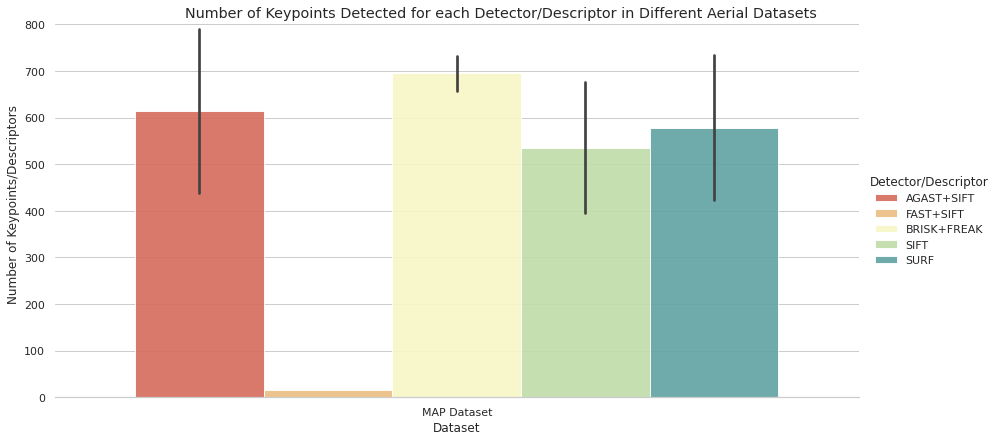

In [59]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [60]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [61]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

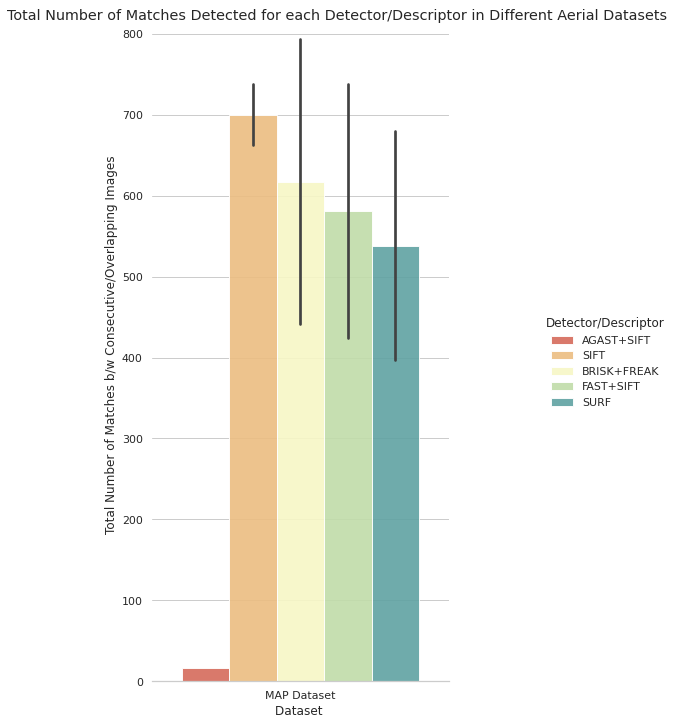

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [63]:
df_match_5['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak + num_good_matches_agast + num_good_matches_fast
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

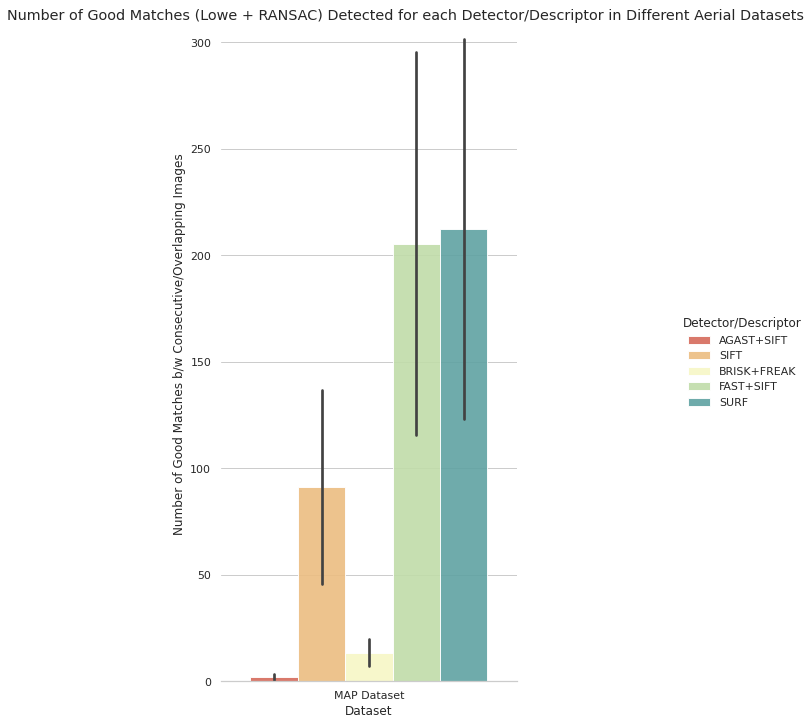

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [65]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

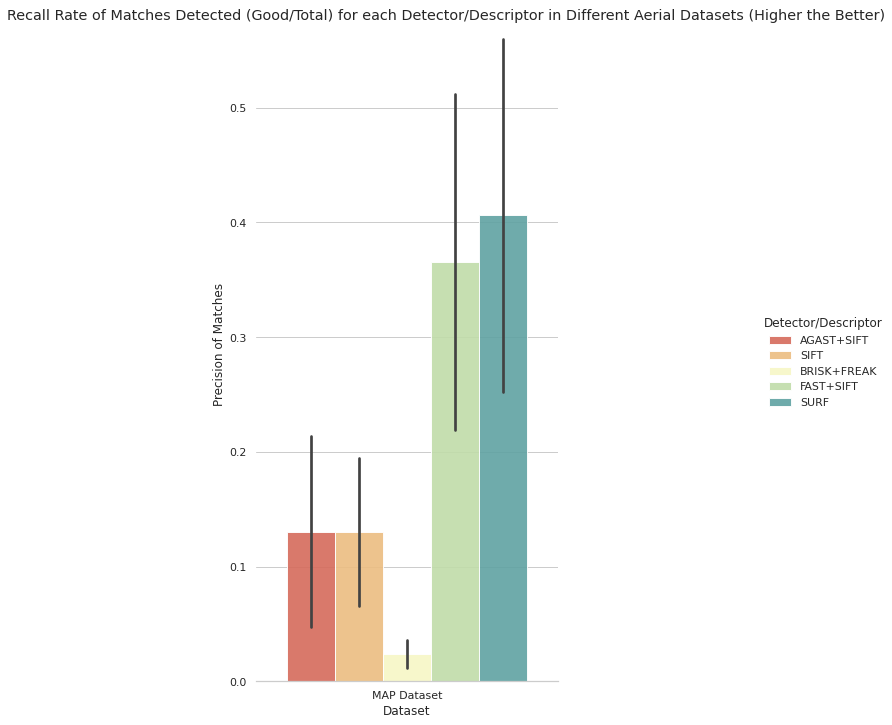

In [66]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [67]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

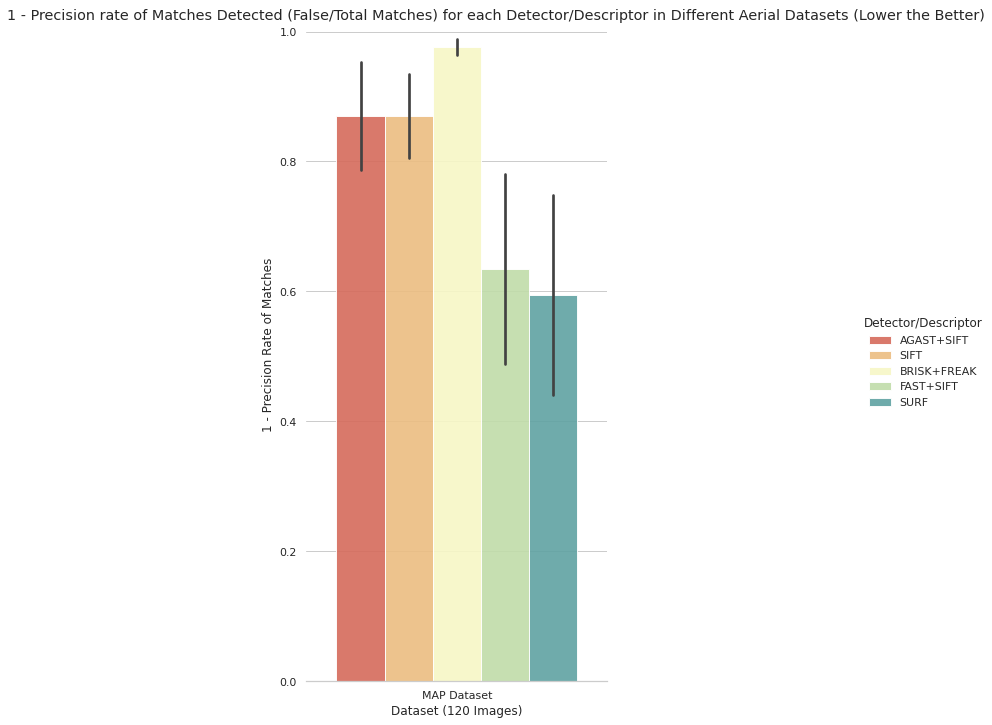

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [69]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

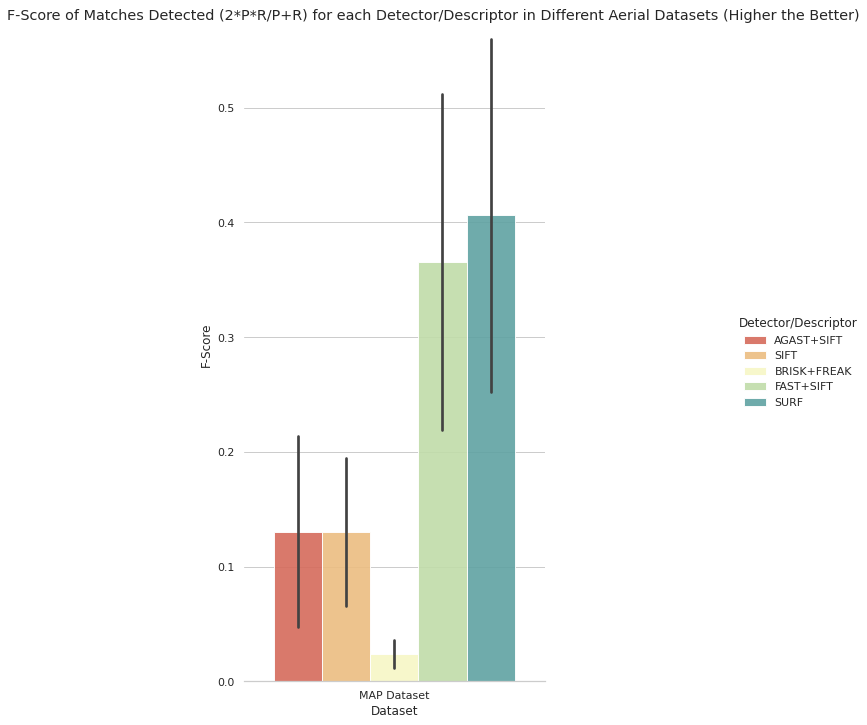

In [70]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [71]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [72]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [73]:
print(df_time_5)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  406.467279          AGAST+SIFT
1  MAP Dataset  293.452579           FAST+SIFT
2  MAP Dataset  668.109893         BRISK+FREAK
3  MAP Dataset  724.091359                SURF
4  MAP Dataset  575.900499                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

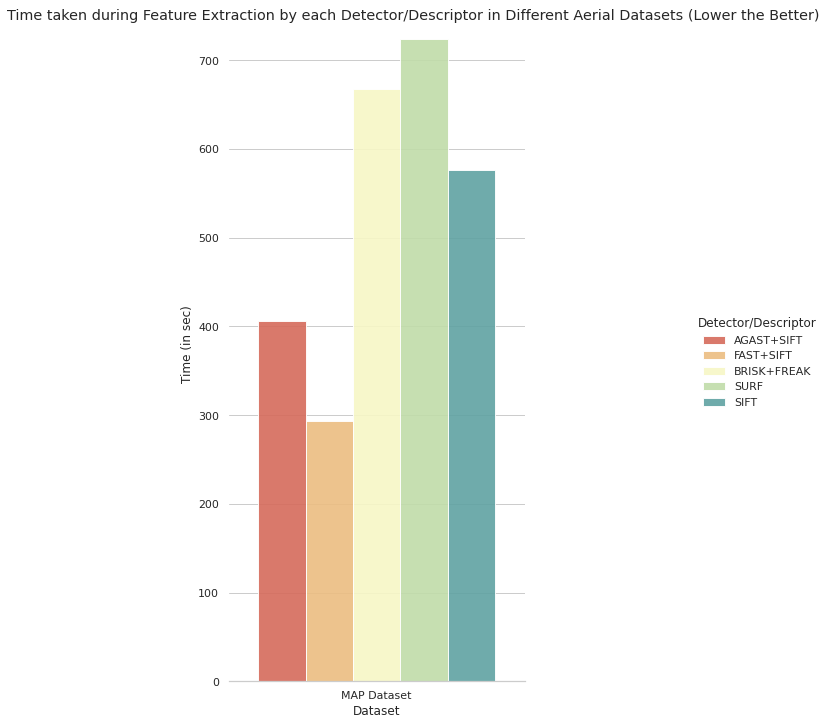

In [74]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_7.png')

In [75]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU